In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetMobile,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-nasnetmobile-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = NASNetMobile(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 232s 26ms/step - loss: 0.6877 - acc: 0.7971 - val_loss: 3.7682 - val_acc: 0.4033
Epoch 2/100
9112/9112 [==============================] - 137s 15ms/step - loss: 0.3431 - acc: 0.8955 - val_loss: 5.2566 - val_acc: 0.3369
Epoch 3/100
9112/9112 [==============================] - 137s 15ms/step - loss: 0.2586 - acc: 0.9205 - val_loss: 6.4405 - val_acc: 0.3018
Epoch 4/100
9112/9112 [==============================] - 142s 16ms/step - loss: 0.2064 - acc: 0.9346 - val_loss: 5.4306 - val_acc: 0.4561
Epoch 5/100
9112/9112 [==============================] - 139s 15ms/step - loss: 0.1749 - acc: 0.9473 - val_loss: 8.5727 - val_acc: 0.2930
Epoch 6/100
9112/9112 [==============================] - 140s 15ms/step - loss: 0.1508 - acc: 0.9525 - val_loss: 10.9911 - val_acc: 0.2217
Epoch 7/100
9112/9112 [==============================] - 139s 15ms/step - loss: 0.1428 - acc: 0.9551 - val_loss: 10.9032 - 

9120/9120 [==============================] - 137s 15ms/step - loss: 0.0198 - acc: 0.9942 - val_loss: 1.6170 - val_acc: 0.7963
Epoch 69/100
9120/9120 [==============================] - 137s 15ms/step - loss: 0.0243 - acc: 0.9925 - val_loss: 2.0462 - val_acc: 0.7608
Epoch 70/100
9120/9120 [==============================] - 139s 15ms/step - loss: 0.0237 - acc: 0.9925 - val_loss: 7.6739 - val_acc: 0.2992
Epoch 71/100
9120/9120 [==============================] - 137s 15ms/step - loss: 0.0175 - acc: 0.9946 - val_loss: 4.1650 - val_acc: 0.6004
Epoch 72/100
9120/9120 [==============================] - 139s 15ms/step - loss: 0.0069 - acc: 0.9980 - val_loss: 3.3128 - val_acc: 0.6132
Epoch 73/100
9120/9120 [==============================] - 138s 15ms/step - loss: 0.0048 - acc: 0.9984 - val_loss: 3.4028 - val_acc: 0.6624
Epoch 74/100
9120/9120 [==============================] - 137s 15ms/step - loss: 0.0169 - acc: 0.9945 - val_loss: 1.8662 - val_acc: 0.7392
Epoch 75/100
9120/9120 [================

Epoch 62/100
9132/9132 [==============================] - 138s 15ms/step - loss: 0.0367 - acc: 0.9884 - val_loss: 13.5991 - val_acc: 0.0916
Epoch 63/100
9132/9132 [==============================] - 140s 15ms/step - loss: 0.0172 - acc: 0.9944 - val_loss: 9.5209 - val_acc: 0.2022
Epoch 64/100
9132/9132 [==============================] - 138s 15ms/step - loss: 0.0229 - acc: 0.9931 - val_loss: 9.4752 - val_acc: 0.2948
Epoch 65/100
9132/9132 [==============================] - 138s 15ms/step - loss: 0.0211 - acc: 0.9932 - val_loss: 13.3290 - val_acc: 0.1026
Epoch 66/100
9132/9132 [==============================] - 138s 15ms/step - loss: 0.0247 - acc: 0.9922 - val_loss: 11.9596 - val_acc: 0.1653
Epoch 67/100
9132/9132 [==============================] - 139s 15ms/step - loss: 0.0119 - acc: 0.9963 - val_loss: 12.3331 - val_acc: 0.1723
Epoch 68/100
9132/9132 [==============================] - 137s 15ms/step - loss: 0.0055 - acc: 0.9988 - val_loss: 9.4585 - val_acc: 0.2819
Epoch 69/100
9132/9132 

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.7431


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

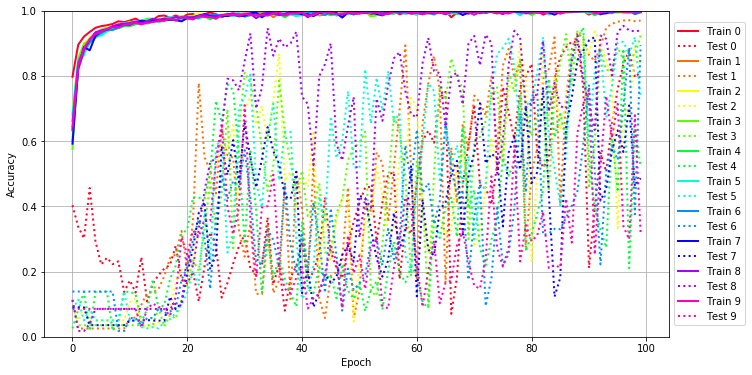

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

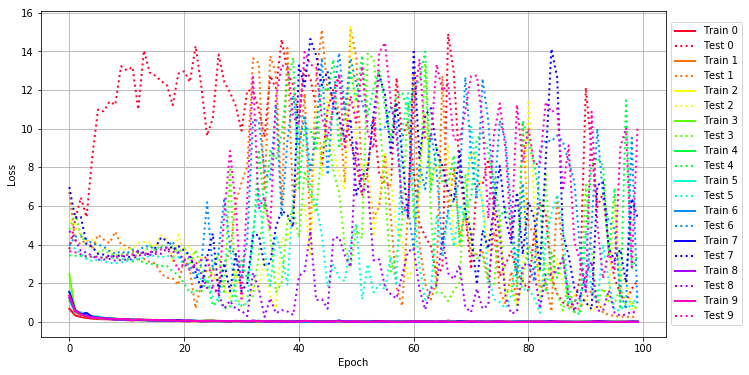

In [ ]:
plot_loss(history)

Plotting the confusion matrix


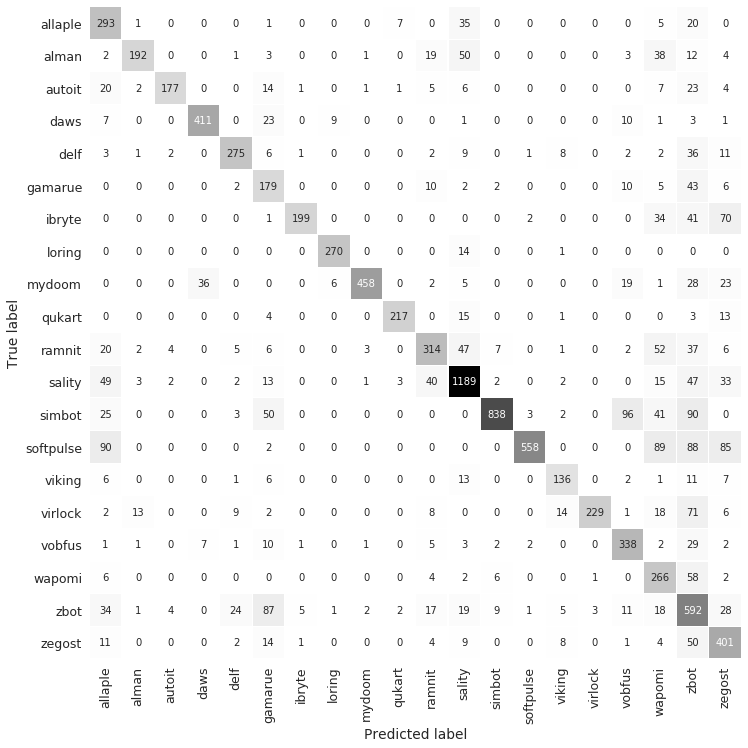

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


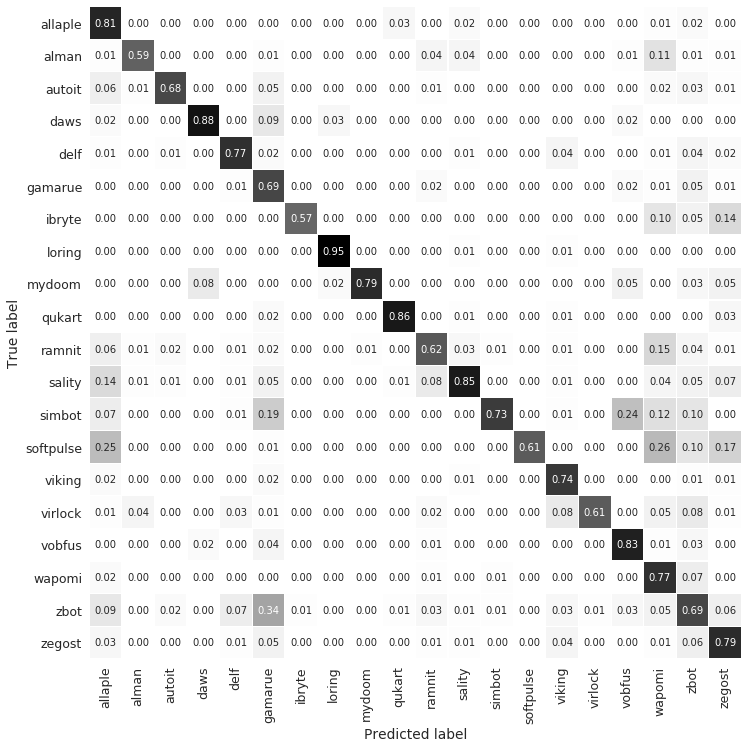

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'acc': [0.7970807727122119, 0.8955223880597015, 0.9205443371378402, 0.9345917472512812, 0.9473222125717378, 0.9524802459343366, 0.9551141352063214, 0.9591747147143149, 0.9674056190686648, 0.9646619841966637, 0.9697102721685689, 0.9756365232660228, 0.9651009658117687, 0.9723441616498765, 0.9713564531336342, 0.9834284461099292, 0.9849648814749781, 0.9781606672519754, 0.9851843722563652, 0.978270412642669, 0.9880377524143986, 0.9896839332748024, 0.9814530290774445, 0.9896839332748024, 0.9941834942932397, 0.9893546971027217, 0.9795873574356535, 0.987379280070237, 0.9915496049165935, 0.9901229148375769, 0.9910008779631255, 0.9919885864793678, 0.9933055311676909, 0.9900131694468832, 0.9956101843722563, 0.9911106233538192, 0.9937445127304653, 0.9923178226514486, 0.9896839332748024, 0.9931957857769974, 0.9938542581211589, 0.9918788410886743, 0.9963784021071115, 0.99571992976295, 0.9944029850746269, 0.9958296751536435, 0.9907813872863998, 0.9928665496049166, 0.9937445127304653, 0.9976953467954

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

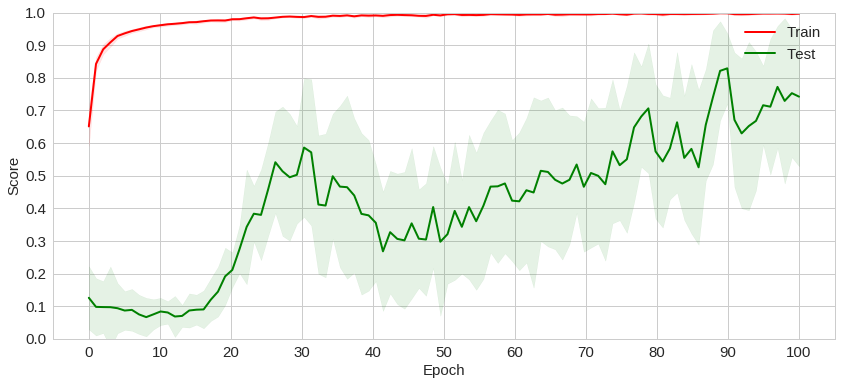

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

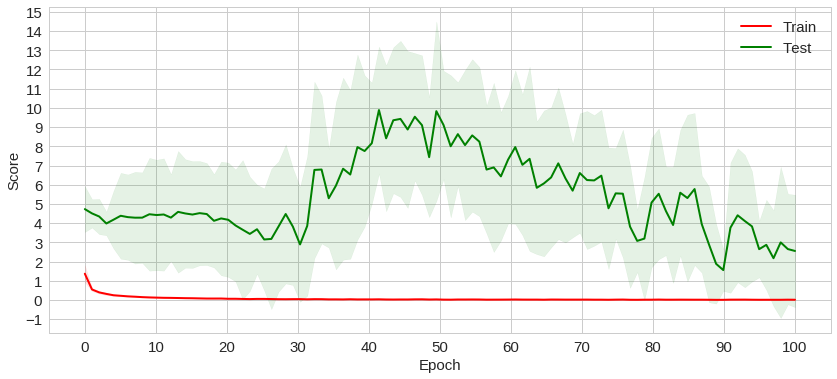

In [ ]:
plot_mean_loss(history)

In [21]:
hist = [{'acc': [0.7970807727122119, 0.8955223880597015, 0.9205443371378402, 0.9345917472512812, 0.9473222125717378, 0.9524802459343366, 0.9551141352063214, 0.9591747147143149, 0.9674056190686648, 0.9646619841966637, 0.9697102721685689, 0.9756365232660228, 0.9651009658117687, 0.9723441616498765, 0.9713564531336342, 0.9834284461099292, 0.9849648814749781, 0.9781606672519754, 0.9851843722563652, 0.978270412642669, 0.9880377524143986, 0.9896839332748024, 0.9814530290774445, 0.9896839332748024, 0.9941834942932397, 0.9893546971027217, 0.9795873574356535, 0.987379280070237, 0.9915496049165935, 0.9901229148375769, 0.9910008779631255, 0.9919885864793678, 0.9933055311676909, 0.9900131694468832, 0.9956101843722563, 0.9911106233538192, 0.9937445127304653, 0.9923178226514486, 0.9896839332748024, 0.9931957857769974, 0.9938542581211589, 0.9918788410886743, 0.9963784021071115, 0.99571992976295, 0.9944029850746269, 0.9958296751536435, 0.9907813872863998, 0.9928665496049166, 0.9937445127304653, 0.9976953467954346, 0.9996707638279192, 0.9991220368744512, 0.9877085162423178, 0.9936347674444331, 0.9979148375768218, 0.9990122914837577, 0.9992317822651449, 0.9886962247585601, 0.9940737489025461, 0.9930860404386345, 0.9949517120280948, 0.9995610184372257, 0.9996707638279192, 0.9991220368744512, 0.9996707638279192, 0.999451273046532, 0.9795873573309921, 0.9940737489025461, 0.9989025461977254, 0.9974758560140474, 0.9989025460930641, 0.9964881474978051, 0.9945127304653204, 0.9974758560140474, 0.9972563652326603, 0.99571992976295, 0.9986830553116769, 0.9955004389815628, 0.9979148375768218, 0.9992317822651449, 0.9997805092186128, 0.9991220368744512, 0.9875987708516243, 0.9944029850746269, 0.9978050921861282, 0.999451273046532, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9986830553116769, 0.9878182616330115, 0.9976953467954346, 0.9981343283582089, 0.994622475856014, 0.9972563652326603, 0.9996707638279192, 0.9995610184372257, 0.9990122914837577, 0.9970368744512731, 0.9959394206489985], 'val_acc': [0.4033203125, 0.3369140625, 0.3017578125, 0.4560546875, 0.29296875, 0.2216796875, 0.2421875, 0.22265625, 0.2314453125, 0.1376953125, 0.1728515625, 0.1357421875, 0.244140625, 0.1083984375, 0.1630859375, 0.189453125, 0.208984375, 0.220703125, 0.279296875, 0.1748046875, 0.1630859375, 0.19921875, 0.1083984375, 0.21484375, 0.3203125, 0.28125, 0.1201171875, 0.1650390625, 0.224609375, 0.27734375, 0.3134765625, 0.2080078125, 0.1943359375, 0.2177734375, 0.3662109375, 0.1611328125, 0.220703125, 0.080078125, 0.181640625, 0.216796875, 0.2900390625, 0.173828125, 0.19921875, 0.2578125, 0.427734375, 0.259765625, 0.2119140625, 0.1796875, 0.2802734375, 0.3525390625, 0.41015625, 0.4580078125, 0.4599609375, 0.2939453125, 0.4111328125, 0.498046875, 0.50390625, 0.1767578125, 0.337890625, 0.3154296875, 0.47265625, 0.6005859375, 0.6318359375, 0.5947265625, 0.7333984375, 0.7509765625, 0.0703125, 0.1826171875, 0.46484375, 0.5927734375, 0.7119140625, 0.46484375, 0.4580078125, 0.40625, 0.5283203125, 0.765625, 0.6875, 0.6044921875, 0.7646484375, 0.798828125, 0.8369140625, 0.560546875, 0.51953125, 0.544921875, 0.7919921875, 0.857421875, 0.8876953125, 0.9052734375, 0.9033203125, 0.763671875, 0.2109375, 0.3955078125, 0.5634765625, 0.505859375, 0.6533203125, 0.759765625, 0.8369140625, 0.8779296875, 0.7958984375, 0.8115234375], 'val_loss': [3.7682353472337127, 5.25657144933939, 6.440523875877261, 5.430644690595727, 8.572749892249703, 10.991111692041159, 10.903160698886495, 11.404613399878144, 11.23875068873167, 13.236442357301712, 13.027431443333626, 13.194546911865473, 11.006213422864676, 14.04758058488369, 12.913377679884434, 12.742327392101288, 12.473192177712917, 12.248915888369083, 11.224493506830186, 12.856292828917503, 12.976161055965349, 12.419270351529121, 14.27933219820261, 12.185687074554178, 9.638773757964373, 10.560833223164082, 13.837790476404052, 12.425327092409134, 11.879012260586023, 11.180833104997873, 9.900774970650673, 11.990531276911497, 11.954769384115934, 11.016913071274757, 9.559062853455544, 12.741787537932396, 12.085441062226892, 14.620029464364052, 12.909368492662907, 12.264826945960522, 10.514622531831264, 13.150264541618526, 12.593852575868368, 11.116295091807842, 8.048159846104681, 10.979240912944078, 12.031324544921517, 12.710268538445234, 10.854353791102767, 9.267606124690776, 8.241726018031656, 6.534999458526727, 7.900306414812803, 10.563092164695263, 7.621493648737669, 7.205635532736778, 6.976641071494669, 12.635635003447533, 9.55628078430891, 10.384993206709623, 7.7578395644056855, 5.1012105914014905, 4.434914833878595, 3.910340042831366, 2.3820365152851224, 2.799134740309114, 14.91777565702796, 12.87417821813142, 7.826259993300027, 5.535219926601485, 2.736319846765364, 7.154955972917378, 7.114357164129615, 8.42067688703537, 5.912817094554612, 2.3696630974059314, 2.9887092900462457, 3.660221540535531, 2.5277138836744295, 2.130112588392993, 1.5914497237172407, 4.614089608192444, 6.206741829402745, 5.625264750648057, 2.3685648647289104, 1.4651635701748114, 1.0112722141498196, 0.8493747634345192, 0.9173031843615758, 2.3070030614258887, 12.125016000121832, 8.793077951297164, 5.945309454342427, 6.677799497376327, 3.829523466591127, 2.2692217501906677, 1.4619517155165824, 1.03768667944813, 1.7253548662409854, 2.1291068469436154], 'loss': [0.6877320013986123, 0.34314597070321795, 0.2586015451853217, 0.20636234390267266, 0.17494667528476812, 0.15079297745294534, 0.1428139311072594, 0.13374251802799417, 0.10503491266901238, 0.10833832717977326, 0.09379851231572264, 0.07789209649486825, 0.10524182078118671, 0.08571299724280834, 0.09248985160228856, 0.05016194485190069, 0.05147038239327891, 0.07097943299335507, 0.04213327788919813, 0.06299581194242922, 0.03736000171313888, 0.0327873379412157, 0.05283716425070289, 0.03349431283529553, 0.01878068933187378, 0.034259191998149245, 0.06287249351111245, 0.03920206274902976, 0.023367410076831577, 0.03471136845053334, 0.034111339752372745, 0.027523851473016468, 0.022508150495043525, 0.03210075745366013, 0.01752892275156829, 0.029668237715623793, 0.021517659633052612, 0.024173168720760488, 0.033833857842609026, 0.021400516233896796, 0.01872451048593711, 0.02813990080339049, 0.012977125283175935, 0.014848216391282292, 0.016250667273857468, 0.01372479220074744, 0.032865366998740285, 0.022753195839113984, 0.02247961317515817, 0.009783102765829247, 0.0020126416164943975, 0.0038406382998427938, 0.037253240721774786, 0.0242243966646932, 0.006313496877789537, 0.0046162953177956104, 0.0029745639292891664, 0.03512440812258106, 0.015562542182816464, 0.02776759982300704, 0.020295478984737776, 0.0028097358848342057, 0.002220092487310064, 0.002339448693015357, 0.0012879706940307678, 0.0020315904765300266, 0.07403816792584916, 0.01924198900213667, 0.004820185150158189, 0.007848390762968251, 0.004734428084430524, 0.010583178989060261, 0.020300377201383335, 0.008597435145601736, 0.007590365535720031, 0.014482404874940727, 0.004122118236615747, 0.012917252157005081, 0.006698200151777241, 0.0026214657055198755, 0.0010886382905483803, 0.00468259011418504, 0.04263692527627002, 0.01990058413173371, 0.006989902888858384, 0.0026882117354186277, 0.0009537083140444406, 0.0009584287760441102, 0.0007782870574284469, 0.00390480144459702, 0.04293294936558354, 0.007181358353232023, 0.005953042765054565, 0.02049411001814092, 0.008474660727034055, 0.002200059809586031, 0.002249941299929397, 0.0030010419384519, 0.011178146285798772, 0.012932258637064957]},
{'acc': [0.6321044548289776, 0.8307000222320171, 0.8909370199954376, 0.9104674128631188, 0.9316436252966507, 0.9383366249725696, 0.9422865922392945, 0.950186526328031, 0.9544656573221928, 0.95687952600395, 0.9655475094178697, 0.9628044767209201, 0.964998902800001, 0.966864165020847, 0.9692780337941628, 0.9690585911784069, 0.9765196401141102, 0.9719113452747932, 0.9778362958086461, 0.9723502305063051, 0.9795918367346939, 0.9800307220577644, 0.9861751153904904, 0.9846390170801986, 0.9810182137371077, 0.977397410577134, 0.9878209348255431, 0.9866140004388853, 0.9886987052885671, 0.9873820495940312, 0.9836515251261795, 0.9867237218383218, 0.9845292955892034, 0.9944042132982225, 0.9928681150794892, 0.9799210006583279, 0.9916611807843899, 0.9921000658327848, 0.988369541364933, 0.989357033135835, 0.9895764757515909, 0.9950625411454904, 0.9960500329163924, 0.9851876236195886, 0.9880403774412991, 0.9930875576952453, 0.9945139346061005, 0.9939653280667106, 0.9926486723721747, 0.988918147904323, 0.9927583937716112, 0.9936361641430765, 0.9934167216188792, 0.9962694755321484, 0.9941847706824666, 0.9915514592933948, 0.991002852937122, 0.9959403116085144, 0.9981347377660742, 0.990344525089854, 0.9885889839806891, 0.9942944919903445, 0.9963791968400263, 0.9982444590739522, 0.995940311700073, 0.9886987054716843, 0.9926486723721747, 0.9918806232170287, 0.9950625411454904, 0.9910028527540048, 0.9955014263770025, 0.9976958525345622, 0.9960500329163924, 0.9969278033794163, 0.9919903445249068, 0.9955014263770025, 0.9965986396388995, 0.9964889181479043, 0.9952819839443636, 0.9911125741534415, 0.9935264429267572, 0.9950625411454904, 0.9983541803818301, 0.9984639016897081, 0.9961597542242704, 0.9921000659243433, 0.9944042132982225, 0.9955014263770025, 0.9983541804733888, 0.9972569673030502, 0.9933070002194426, 0.9955014263770025, 0.9985736229975861, 0.9985736229975861, 0.9984639016897081, 0.9985736229975861, 0.9984639016897081, 0.9983541803818301, 0.9985736229975861, 0.9984639016897081], 'val_acc': [0.11252446183953033, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.05675146771037182, 0.05870841487279843, 0.09784735812133072, 0.13502935444072267, 0.1360078291883674, 0.14677103823178436, 0.1859099815969598, 0.24168297549283202, 0.2534246584673917, 0.32485323001260624, 0.2045009784735812, 0.3571428585425748, 0.7778864979977244, 0.550880626223092, 0.5088062633973511, 0.4393346398310652, 0.6360078297715831, 0.5567514688768033, 0.5489236802270968, 0.32876712363760063, 0.2455968688845401, 0.3473581216806535, 0.13209393346379647, 0.13013698630136986, 0.34148728019337365, 0.13405088062622308, 0.17318982387475537, 0.4667318995218221, 0.11545988258317025, 0.5058708418372093, 0.39432485451203736, 0.17906066536203522, 0.5362035234380375, 0.11741682974559686, 0.057729941291585124, 0.18688845447831423, 0.19765166375501747, 0.23385518631823143, 0.45792563635775724, 0.057729941291585124, 0.1379647749510763, 0.403131115809812, 0.3864970649291858, 0.5655577301745779, 0.5322896285299685, 0.3522504892367906, 0.5185909980940843, 0.695694716709234, 0.8933463796477495, 0.5078277889996359, 0.17906066536203522, 0.6555772997628453, 0.7769080238332954, 0.8610567532173575, 0.7544031314653893, 0.16536203522504891, 0.5802348349425658, 0.4099804318114503, 0.6536203526004186, 0.5714285717785008, 0.7397260284470485, 0.7181996096603558, 0.6780821930638965, 0.7984344433198469, 0.5724070468177535, 0.8317025440313112, 0.8825831702544031, 0.7935420743639922, 0.8444227005870841, 0.2759295501645997, 0.5009784759140761, 0.5782778874302097, 0.7935420752971373, 0.8209393346379648, 0.9178082191780822, 0.4060665362035225, 0.7309197660994856, 0.8816046966731899, 0.9324853228962818, 0.9119373786239475, 0.8639921743109268, 0.845401176267874, 0.8884540117416829, 0.9471624266144814, 0.9598825831702544, 0.9657534246575342, 0.9696673189823874, 0.9706457925636007, 0.9677103718199609, 0.9696673189823874], 'val_loss': [6.724903528471049, 4.229393129012823, 4.025249631437537, 4.28348717437565, 3.801826342211311, 4.509614914597364, 4.263600124538295, 4.084202217729124, 4.67306356747323, 4.006804712131299, 3.927148361728616, 3.7248674955386707, 3.2354991823259867, 3.266123798728689, 3.1091115001129777, 3.027958932921378, 2.505438471143726, 2.2905655877697493, 2.2546276110725625, 1.9244994104725042, 3.3335919562151286, 2.667214011551116, 0.7022464444492661, 1.9797330832586364, 2.745570664711428, 2.8042813751212305, 1.8723649000730767, 2.964198082441249, 3.6588877018016204, 6.187519510198246, 7.217716830117362, 8.048941745216833, 13.651394920573075, 13.3981849013476, 6.797496045405618, 13.765943665327159, 12.841085915462845, 6.012672718724196, 14.184350978604968, 5.8622539265373605, 8.34108338034083, 11.830472651857354, 4.393807618352065, 12.694495949493229, 15.116930952277436, 11.90430750725554, 11.697119236925577, 10.922957024695588, 7.222490783205229, 15.175901722768048, 13.705427423615278, 7.378716368497934, 7.535136612894017, 5.363606215048209, 5.982861087105281, 8.55402780179875, 5.47317767564623, 1.7763630355290942, 0.8313283038357833, 5.614772576367631, 12.949540388327522, 4.125041419241, 1.9798556412800283, 1.163515286687474, 2.138427953007989, 12.734814272468103, 5.708726530020767, 8.009891364439126, 4.4606409633349395, 5.570045641869482, 3.553986642756468, 3.4958453986000113, 3.7398365923735515, 2.1910813558749234, 4.67514557608653, 1.602028481973939, 0.911006672008634, 2.613933996591709, 1.1733730376940017, 10.214173531578945, 4.916172088708897, 4.659824489917988, 1.7229662397214573, 2.020855459758888, 0.5478377736993388, 6.582973669477478, 3.611165787918533, 0.9439003371975673, 0.5308450468038954, 0.7328412739282153, 1.2250338685999542, 1.650783142878498, 1.1833442127272105, 0.460564556504774, 0.37051467490467144, 0.31414667524542544, 0.2843675282478387, 0.2612801120542453, 0.2642464196416307, 0.2743380701368456], 'loss': [1.3549898565927305, 0.6086708201319863, 0.3949357568236697, 0.2916910500789463, 0.22867241231056323, 0.20202175025383265, 0.18542749882202178, 0.16226240297681752, 0.14837183395965936, 0.13616613757816817, 0.11164924355388499, 0.1145240136679521, 0.11545642455297916, 0.10019139943136336, 0.09776396689569058, 0.09718168988441307, 0.07123470482577803, 0.07907200787579798, 0.0708341486652913, 0.09034719777742917, 0.059072004568828274, 0.06332612332076795, 0.043802398462351254, 0.04857791276298756, 0.05600939732390733, 0.07010767611967011, 0.04088491978064925, 0.043002602337604716, 0.03787635792081682, 0.03732223312243973, 0.05181746496756116, 0.04547652834525672, 0.04833231026623831, 0.022317336607022002, 0.023354720618752184, 0.05989061478158144, 0.026574612983038728, 0.02378260246579696, 0.03365102444521292, 0.033321999886213115, 0.03638569666942137, 0.014414434499941496, 0.01575853943289812, 0.04617067684007848, 0.039220769040768655, 0.022606450590154408, 0.018116673196558953, 0.019782569337935024, 0.026822203098145536, 0.03743342701105034, 0.025634215270046046, 0.019100678049995736, 0.02053612940274647, 0.014246182164933934, 0.01964852295793515, 0.028801812136293174, 0.029076608263230715, 0.012692464702536743, 0.0063369188818271326, 0.02888598429877339, 0.0383824253438097, 0.01963447865048848, 0.010643175052256298, 0.005651432561058129, 0.01378375046130085, 0.04151777452411287, 0.02123892828125739, 0.02989905706171442, 0.015110001765721044, 0.027440912060381264, 0.01546879421408859, 0.008660083870441315, 0.013514577512285627, 0.008657562775266234, 0.028926732481734933, 0.015338292553282742, 0.010938657194740846, 0.010266662772786803, 0.015100339226389465, 0.02976519341373209, 0.018853825709402104, 0.014743930836730361, 0.005844915484787865, 0.005137609948933996, 0.013242517319562988, 0.026767467013774058, 0.024330629351141154, 0.014026830563338213, 0.0061782691077772985, 0.010161868754434433, 0.02077564776458786, 0.013618472855077233, 0.00534684235615607, 0.004787522213166907, 0.004522861141555142, 0.004388698870661217, 0.004373933225108085, 0.004330901697962293, 0.004486610428919611, 0.004577435762475757]},
{'acc': [0.6884598508640672, 0.8520184292402012, 0.8994076350845229, 0.918056165063104, 0.9296840720136943, 0.9381307593141014, 0.9485519965943039, 0.9517332164275641, 0.9577665643871955, 0.96105748135147, 0.963141728933049, 0.9665423432375685, 0.9700526547254099, 0.9707108380868802, 0.9702720491443616, 0.975866608213782, 0.9714787188409033, 0.9791575253349797, 0.9767441860988193, 0.9735629662655592, 0.9801448003510311, 0.9838745063624397, 0.991224221149627, 0.9863975427819219, 0.978828433575783, 0.9845326897762177, 0.9850811760589814, 0.9880430013163668, 0.9902369460289601, 0.9890302764370338, 0.9851908731899957, 0.9931987713909609, 0.9924308907415533, 0.9865072400175515, 0.9902369460289601, 0.991772707380083, 0.9937472575691093, 0.984422992540588, 0.991772707380083, 0.9949539271610356, 0.9934181658622203, 0.9941860465116279, 0.9941860465116279, 0.9888108819657745, 0.9914436156731941, 0.9896884600077349, 0.9925405879771829, 0.9967090829834179, 0.9937472575691093, 0.9885914874945151, 0.9913339183852566, 0.9965993856954805, 0.9970381746379992, 0.9978060552874067, 0.991553312856516, 0.9907854322071084, 0.9956121106271212, 0.9947345326897762, 0.9930890741553313, 0.9976963580517771, 0.998025449758666, 0.993747257621417, 0.990895129442738, 0.9955024133391839, 0.9939666520403686, 0.9939666520403686, 0.9955024133914916, 0.9951733216322949, 0.9968187801667397, 0.9952830188679245, 0.9941860465116279, 0.9955024133391839, 0.9953927161035542, 0.998354541465555, 0.9957218078104432, 0.990895129442738, 0.9971478718736287, 0.9970381746379992, 0.9981351469942957, 0.9976963580517771, 0.9877139096094778, 0.9940763493283059, 0.9968187801667397, 0.9937472575691093, 0.9979157525230364, 0.9976963580517771, 0.9935278630978499, 0.9969284774023695, 0.9975866608684552, 0.9942957437472576, 0.9963799912242212, 0.9971478718736287, 0.9985739359368144, 0.9975866608161474, 0.9975866608161474, 0.992211496270294, 0.9938569548047389, 0.9963799912242212, 0.998025449758666, 0.998683633172444], 'val_acc': [0.0892156862745098, 0.05, 0.0892156862745098, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10588235294117647, 0.11764705882352941, 0.03235294117647059, 0.03235294117647059, 0.03235294117647059, 0.04411764705882353, 0.03823529411764706, 0.08529411764705883, 0.16666666666666666, 0.2058823529850034, 0.19705882352941176, 0.21568627450980393, 0.38235294117647056, 0.4029411783405379, 0.5147058837554034, 0.5264705889365252, 0.5901960796000911, 0.5764705891702689, 0.6490196083106247, 0.43823529435139075, 0.6921568641475603, 0.7401960798338347, 0.6500000014024623, 0.7078431386573641, 0.6029411769380757, 0.7245098053240309, 0.8676470595247605, 0.47647058870278153, 0.5058823536424076, 0.3960784314602029, 0.49411764822754206, 0.4598039229710897, 0.6313725494870952, 0.2078431381898768, 0.39019607843137255, 0.23137254901960785, 0.3607843137254902, 0.4274509808596443, 0.4215686275094163, 0.04607843137254902, 0.23039215690657205, 0.3490196083106247, 0.36666666701728223, 0.5196078440722297, 0.4352941177639307, 0.32058823599534875, 0.3323529418777017, 0.5529411778730504, 0.5343137264251709, 0.732352941643958, 0.7039215695624258, 0.37843137395148185, 0.2568627446305518, 0.3764705884690378, 0.36176470588235293, 0.31568627497729135, 0.32254901960784316, 0.5235294119984496, 0.5607843148942088, 0.44803921708873673, 0.27549019619530324, 0.3196078433709986, 0.4647058823529412, 0.6107843137254902, 0.5107843137254902, 0.5647058837554034, 0.7647058837554034, 0.7715686274509804, 0.8931372558369356, 0.7960784332424986, 0.22941176610834457, 0.5127450985067031, 0.8666666671341541, 0.6666666666666666, 0.7950980392156862, 0.6352941185820337, 0.7245098053240309, 0.8431372553694482, 0.8313725490196079, 0.9098039215686274, 0.8676470588235294, 0.936274510271409, 0.8980392156862745, 0.8509803926243501, 0.7794117651733697, 0.3333333339176926, 0.7098039225036022, 0.6754901965459188, 0.8921568636800729, 0.8313725499545827], 'val_loss': [5.239921208923938, 5.0596302556056605, 4.465248379052854, 4.244389431149352, 4.262913594526403, 3.9778011322021483, 3.83717763190176, 3.7035262724932503, 3.638521015877817, 3.8161927503698014, 3.739443369472728, 3.812314338310092, 4.091100068185844, 4.147021370308072, 4.108708005792955, 3.8827153074975107, 4.481380182154038, 4.303796562494016, 3.0793735279756436, 4.535137960022571, 3.6432338265811697, 3.9685564714319566, 2.773441059215396, 3.317753869411992, 3.2414477097053154, 2.260644414027532, 2.2421988602508516, 1.8335402840711907, 1.2470399806182482, 2.7141208248979907, 1.3395333434493901, 1.2978606872744494, 1.8006483005380314, 1.6659945177120343, 3.362671965441476, 1.3214301525968932, 0.702929081597911, 4.347318437987683, 4.239311850070953, 5.65259297875797, 5.65387245907503, 6.040356589385934, 3.4154133294142928, 11.174980631426854, 7.582838418575771, 11.63500602572572, 8.966874496609558, 7.633781729024999, 6.8588839234090315, 15.345883002935672, 9.252976346483418, 7.96110985512827, 8.29125427884214, 4.434371006021313, 6.442697347759032, 8.807871646039626, 7.296420942948145, 4.856386399210668, 4.113453829259265, 2.264792243657775, 2.791427492099248, 7.036932250565173, 10.799096298447864, 7.1588975256565, 8.006806607559032, 7.866166386884801, 9.110560272254196, 3.9734630412771366, 3.9346639589936125, 6.009176298450021, 8.815231571945489, 8.651280199312696, 6.071469523743088, 3.670850274142097, 5.92765901299084, 5.218444138268127, 1.124531622492463, 2.009037646944703, 0.8992524276627386, 2.081995269701835, 11.498773367030948, 6.296118757304023, 1.1822247677292366, 3.1015786291994885, 2.0249613373449034, 3.264923867758583, 1.8919319667140666, 1.2653968716190347, 1.4064048285655708, 0.9379181475449563, 1.2547831953558024, 0.5787494700385263, 0.8432955355935149, 0.803654531059175, 1.3876456919261175, 6.48322735674241, 2.2127884477961297, 2.1548952878690235, 0.6053900420873248, 0.9294715263931757], 'loss': [1.0823578969487604, 0.4936830886705448, 0.3548144435885184, 0.2813945398251181, 0.25211142498171085, 0.2013057102990705, 0.1689317085849266, 0.1533544198522028, 0.1417859670881406, 0.12442896557467556, 0.10876088891997313, 0.10849448098233457, 0.0923315394549627, 0.093225453258584, 0.09248220276646561, 0.0742454869470781, 0.09170754189950796, 0.06045309210379214, 0.07583064051854174, 0.08599084406946478, 0.0618316072864583, 0.04803431600441779, 0.028319605934597508, 0.04421102051470329, 0.06776278151491205, 0.04578643012495598, 0.04580341114287852, 0.03358840514946003, 0.030345934353029264, 0.03553086445453737, 0.045309595940426196, 0.021799486312710163, 0.02286215222892938, 0.03713294309683466, 0.03154526578487004, 0.023025817463345893, 0.019377650002031357, 0.05192840429552728, 0.026959854617331563, 0.017086580213489924, 0.022306502153436984, 0.01768918117560038, 0.017654820471169296, 0.03476540084901763, 0.02903940667389692, 0.032580605143762494, 0.022058840685396035, 0.011793011854246258, 0.022417024314147767, 0.0449658755733341, 0.028379504135339184, 0.01199714840874388, 0.012168989944756037, 0.008086059498025034, 0.03014772385901554, 0.03173865867262376, 0.013283102190797922, 0.015031361881283126, 0.02421568150042932, 0.009159790492605381, 0.007912756556303838, 0.01841926272269274, 0.029134731233802634, 0.016269303010808308, 0.02048989427880508, 0.01884098962443973, 0.016376272292688985, 0.017266925481692622, 0.010043210307093882, 0.015140825061663851, 0.021094308313299, 0.016138109035943263, 0.013915042754718412, 0.0057399054629197685, 0.015454299950852984, 0.030296960086323186, 0.01079891354702911, 0.009997998138988015, 0.006729136161472073, 0.0072878970543719035, 0.043484494622862975, 0.019960896657890814, 0.009584371847534088, 0.01882020977857805, 0.007087631784497098, 0.006180283177740482, 0.019599998937391935, 0.011331571819243387, 0.007928099442974006, 0.021896536733395148, 0.010489010657546283, 0.008647367143720198, 0.0046375170291139195, 0.00692977871980919, 0.007624793139121151, 0.030064795297607586, 0.021683341396960074, 0.012703761356460074, 0.006342040941098774, 0.004237992933621662]},
{'acc': [0.5758771929824561, 0.8535087719298246, 0.8985745614035088, 0.9081140350877193, 0.931030701754386, 0.9422149122807018, 0.9474780701754386, 0.9394736842105263, 0.9528508771929824, 0.9599780701754386, 0.9658991228070175, 0.9607456140350877, 0.968311403508772, 0.9754385964912281, 0.9751096491228071, 0.9644736842105263, 0.969078947368421, 0.9789473684210527, 0.9800438596491228, 0.9826754385964912, 0.9800438596491228, 0.9831140350877193, 0.9804824561403509, 0.9808114035087719, 0.981469298245614, 0.9746710526315789, 0.9853070175438596, 0.9916666666666667, 0.9870614035087719, 0.9902412280701754, 0.9881578947368421, 0.9901315789473685, 0.9868421052631579, 0.9916666666666667, 0.9855263157894737, 0.9883771929824562, 0.9939692982456141, 0.9939692982456141, 0.9919956140350877, 0.9825657894736842, 0.9942982456140351, 0.9910087719298246, 0.9958333333333333, 0.9973684210526316, 0.9913377192982457, 0.9860745614035088, 0.987719298245614, 0.9927631578947368, 0.9967105263157895, 0.9927631578947368, 0.9968201754385965, 0.9975877192982456, 0.981469298245614, 0.9854166666666667, 0.9961622807017544, 0.9980263157894737, 0.9978070175438597, 0.9970394736842105, 0.9911184210526316, 0.9927631578947368, 0.9960526315789474, 0.9926535087719298, 0.9905701754385965, 0.9959429824561403, 0.9960526315789474, 0.9983552631578947, 0.9964912280701754, 0.994188596491228, 0.9925438596491228, 0.9925438596491228, 0.9946271929824562, 0.9980263157894737, 0.9983552631578947, 0.9945175438596491, 0.9904605263157895, 0.9952850877192982, 0.9971491228070175, 0.9985745614035088, 0.9985745614035088, 0.9975877192982456, 0.9862938596491229, 0.9945175438596491, 0.9975877192982456, 0.9973684210526316, 0.9980263157894737, 0.9980263157894737, 0.9968201754385965, 0.9946271929824562, 0.9981359649122807, 0.9978070175438597, 0.9916666666666667, 0.9961622807017544, 0.9986842105263158, 0.9986842105263158, 0.9994517543859649, 0.9946271929824562, 0.9973684210526316, 0.9971491228070175, 0.9972587719298246, 0.9961622807017544], 'val_acc': [0.11318897637795275, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03543307086614173, 0.03641732283464567, 0.08759842519685039, 0.031496062992125984, 0.06692913385826772, 0.05511811023622047, 0.1171259842519685, 0.16338582680098654, 0.234251968503937, 0.20275590551181102, 0.3316929143244826, 0.4734251968503937, 0.32972441038747474, 0.4419291338582677, 0.6978346466079471, 0.27165354330708663, 0.6348425196850394, 0.8100393705480681, 0.78051181149295, 0.7135826781040101, 0.5738188976377953, 0.4468503946394432, 0.5246063001512542, 0.7854330708661418, 0.6279527563748397, 0.5305118119622779, 0.45177165448196294, 0.5088582677165354, 0.3700787403921443, 0.39960629968192635, 0.4704724409448819, 0.2588582681858633, 0.2588582677165354, 0.37795275614017576, 0.4222440949575169, 0.5413385826771654, 0.5797244103874747, 0.5954724409448819, 0.6289370088126716, 0.1377952755905512, 0.12598425202716992, 0.2874015752724775, 0.46653543354019406, 0.6771653552693645, 0.6299212607811755, 0.4911417332221204, 0.18602362298589992, 0.5374015757418055, 0.4242125988945248, 0.09645669291338582, 0.5009842519685039, 0.7706692918079106, 0.7253937017260574, 0.8533464566929134, 0.7962598425196851, 0.7608267716535433, 0.2992125988945248, 0.6003937012567295, 0.6131889763779528, 0.6624015748031497, 0.7391732288157846, 0.764763779527559, 0.531496062992126, 0.8129921269229078, 0.75, 0.8503937012567295, 0.701771654012635, 0.6151574807842886, 0.6801181107055484, 0.7204724418835378, 0.4488188985764511, 0.7401574807842886, 0.841535433540194, 0.9281496062992126, 0.7706692918079106, 0.9399606303905877, 0.9212598425196851, 0.46161417322834647, 0.5954724409448819, 0.8779527563748397, 0.8179133862960996, 0.8179133862960996, 0.8877952755905512, 0.8494094492882256, 0.8631889763779528, 0.8631889773166086, 0.9242125988945248], 'val_loss': [4.786397729332991, 5.596004099357785, 4.5115400881279175, 3.9551931816761887, 3.86736313752302, 3.5825148173204555, 3.7248921713491123, 3.5313300861148385, 3.4462897833876722, 3.5374721617210567, 3.496904985172542, 3.564115317787711, 3.5663521721607117, 3.593129525973102, 3.9632030378176473, 3.701775871862577, 3.9901958075095347, 3.8152389526367188, 3.852626389405859, 3.6218361235040377, 3.8313073417333166, 3.042673298693079, 3.731912943321889, 2.7577210411312074, 2.0782688546368457, 2.7796936851786818, 3.5306608249822, 1.4409922779075743, 7.888090352139135, 1.3473472728636426, 0.8085962154455405, 0.9792420298546758, 1.3753380554867543, 3.46501747647843, 6.169861232201884, 4.532360236372147, 1.54227498635525, 2.0400439639663777, 5.200472906378545, 5.867152176386728, 4.369217664214647, 7.814092239995641, 6.616748212829349, 5.651295614054822, 9.060357195185864, 9.635446413295476, 7.837462235623457, 6.678973769578408, 3.9347707223904314, 2.8178513903082827, 4.834745605171212, 4.328409547344826, 13.897098030630998, 13.640403909007395, 10.716296196922542, 6.9235193311112155, 2.6057131669509745, 3.4782690419132574, 5.177282821944379, 11.403281627970888, 5.4072381456448575, 6.7385556125265405, 13.428858892185481, 5.559684386403542, 1.5099339745967504, 1.5006427529454047, 1.0795360123912825, 1.616979385971952, 2.04620232573881, 7.6739283161839165, 4.164964269348017, 3.312812420739876, 3.4027537922304294, 1.8661977743592622, 1.9198355241204286, 5.382962296826868, 1.5112506750561792, 1.6763757715271486, 0.8728056271753722, 2.321518573792666, 3.984783852741828, 3.001302648247697, 2.6680004970416937, 7.634934819120123, 2.1294158474197555, 1.4998878345788285, 0.5853041860484103, 1.9863391535836854, 0.5013339618196927, 0.564598703319914, 7.098521426314576, 3.699845350734296, 0.9583578795318178, 1.7440324319849967, 1.0553100867176628, 0.9398116071326493, 1.8379292275483132, 0.9514508520447347, 1.1187864072202887, 0.579387213895012], 'loss': [2.471915884080686, 0.5314412641943547, 0.3581318332307171, 0.3360933415068869, 0.2531504273627019, 0.2029013741565378, 0.1879937950252114, 0.2125658502017981, 0.15607596210351116, 0.1278710996192929, 0.1098975310477902, 0.12317312150834162, 0.1008959386612109, 0.0822729978661396, 0.0740394429802045, 0.11180320165626574, 0.08986020268578278, 0.07363961186472393, 0.05942074755858222, 0.051603198078207735, 0.060389124161028714, 0.05352503277173495, 0.0583410220155329, 0.05767965540759625, 0.05776223304166802, 0.08484548506073719, 0.04845565691908919, 0.026091425719246136, 0.0412063761744975, 0.030132189131925995, 0.03268166444705505, 0.031310685095683626, 0.041552023417030445, 0.02794328236629729, 0.04361478187493049, 0.036487070653126, 0.0211788409553456, 0.019183182938094862, 0.02569314910429775, 0.05433100718065888, 0.01761378632143437, 0.032574961264005026, 0.01444349580234031, 0.008529082850365835, 0.025823086205925567, 0.03808016616865388, 0.03550947989526577, 0.0207779779612968, 0.011916636849446948, 0.02085237164132227, 0.01016845916228544, 0.00881616396755386, 0.059229953862437436, 0.04575873207020841, 0.01345658108280316, 0.007020769197292235, 0.008021548221879863, 0.01053955810038723, 0.022951977511279677, 0.025141490949241223, 0.013356118701695027, 0.024194572085664397, 0.02936405920806002, 0.013847218474895048, 0.014424371545521609, 0.006204086445927315, 0.012001990191727504, 0.01983775005479529, 0.024257560891393887, 0.023717232858338353, 0.01754618349592388, 0.006941003262899788, 0.004805827066847039, 0.01689118953122967, 0.030660991130481992, 0.013785452025171764, 0.009476228579887103, 0.005112882515054719, 0.003847591848544222, 0.0073704476394962975, 0.04577273918557534, 0.01674006805352659, 0.008971929643569621, 0.009731370029615855, 0.006907886373575597, 0.006545372094142135, 0.008187785705748659, 0.017953944491667546, 0.005747379173570217, 0.006900540433747936, 0.028680142559434834, 0.012091363878492925, 0.003956162620200606, 0.004354642536774216, 0.0023180793746036487, 0.017229853192635234, 0.011080539723543711, 0.008252184374793472, 0.010414419244990999, 0.012190065394974737]},
{'acc': [0.6025219298245614, 0.8255482456140351, 0.8706140350877193, 0.8995614035087719, 0.9169956140350877, 0.9271929824561403, 0.9367324561403508, 0.9434210526315789, 0.9461622807017543, 0.9521929824561404, 0.9525219298245614, 0.9580043859649123, 0.9648026315789474, 0.9600877192982457, 0.9660087719298246, 0.9703947368421053, 0.9730263157894737, 0.9714912280701754, 0.9741228070175438, 0.9721491228070176, 0.975219298245614, 0.9776315789473684, 0.9830043859649122, 0.9821271929824561, 0.9730263157894737, 0.9846491228070176, 0.9857456140350878, 0.9843201754385965, 0.9838815789473684, 0.9843201754385965, 0.9843201754385965, 0.9853070175438596, 0.987390350877193, 0.988048245614035, 0.9895833333333334, 0.9881578947368421, 0.9906798245614035, 0.9790570175438597, 0.9901315789473685, 0.9912280701754386, 0.9892543859649123, 0.9923245614035088, 0.9922149122807018, 0.9952850877192982, 0.9927631578947368, 0.9861842105263158, 0.9910087719298246, 0.9915570175438596, 0.9914473684210526, 0.9887061403508772, 0.9959429824561403, 0.9942982456140351, 0.9922149122807018, 0.9905701754385965, 0.9945175438596491, 0.9924342105263158, 0.9908991228070175, 0.9959429824561403, 0.9945175438596491, 0.9970394736842105, 0.9907894736842106, 0.9933114035087719, 0.9924342105263158, 0.9939692982456141, 0.9951754385964913, 0.9974780701754385, 0.9966008771929824, 0.9891447368421052, 0.993421052631579, 0.9957236842105263, 0.9969298245614036, 0.9918859649122806, 0.9945175438596491, 0.9960526315789474, 0.9973684210526316, 0.9914473684210526, 0.9969298245614036, 0.9971491228070175, 0.9984649122807018, 0.993421052631579, 0.9898026315789473, 0.9949561403508772, 0.9976973684210526, 0.9973684210526316, 0.9979166666666667, 0.9958333333333333, 0.9949561403508772, 0.9971491228070175, 0.9984649122807018, 0.9985745614035088, 0.9959429824561403, 0.9855263157894737, 0.9963815789473685, 0.9978070175438597, 0.9974780701754385, 0.9955043859649123, 0.9970394736842105, 0.9957236842105263, 0.993530701754386, 0.9959429824561403], 'val_acc': [0.025590551181102362, 0.08464566929133858, 0.1377952755905512, 0.017716535433070866, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.017716535433070866, 0.047244094488188976, 0.1377952755905512, 0.1377952755905512, 0.1309055118110236, 0.045275590551181105, 0.08464566929133858, 0.17618110236220472, 0.08562992125984252, 0.0984251968503937, 0.17716535433070865, 0.218503937037207, 0.31397637818741986, 0.3297244094488189, 0.4281496067685405, 0.42618110283153265, 0.4251968503937008, 0.5019685044063358, 0.7234251973197217, 0.6574803154299579, 0.7736220472440944, 0.7559055122803515, 0.561023622516572, 0.2844488193669657, 0.5679133858267716, 0.3868110236220472, 0.1338582679511994, 0.29822834645669294, 0.18208661417322836, 0.2411417325181285, 0.1781496062992126, 0.13188976383819354, 0.09251968506870308, 0.35334645669291337, 0.1466535437764145, 0.13385826818586335, 0.2125984251968504, 0.17716535480003656, 0.1889763784220838, 0.11811023622047244, 0.22244094582054558, 0.14173228440322275, 0.11614173228346457, 0.16535433070866143, 0.07874015748031496, 0.14271653637172668, 0.17027559078584506, 0.08366141732283465, 0.20177165360197308, 0.29133858314649325, 0.19783464613861926, 0.16633858267716536, 0.21555118133702617, 0.18996063003859182, 0.10531496062992125, 0.08858267716535433, 0.35925196853327, 0.3031496063285456, 0.3976377955102545, 0.42716535456537263, 0.3061023622047244, 0.6417322834645669, 0.39370078787090274, 0.45078740204413104, 0.2716535433657526, 0.21850393700787402, 0.297244094488189, 0.3641732284051227, 0.5501968503937008, 0.4940944881889764, 0.5374015748031497, 0.7431102366898004, 0.2618110236220472, 0.3149606299505928, 0.37893700787401574, 0.45078740251345895, 0.7913385836158212, 0.6112204733796007, 0.6830708661417323, 0.6053149606299213, 0.8710629930646401, 0.9124015752724776, 0.9488188981071232, 0.546259842754349, 0.39271653549173685, 0.32874015759764696, 0.2736220472440945, 0.6171259844866325, 0.44389763791260756, 0.8828740166866873, 0.2106299213185085, 0.6397637804662148, 0.5216535437764145], 'val_loss': [3.448960409389706, 3.430328453619649, 3.4155203620279866, 3.3535405782264047, 3.3795681112394558, 3.391855224849671, 3.317110350751501, 3.3128366920891708, 3.33357989881921, 3.2393270102072886, 3.27782865584366, 3.129400011122696, 3.257635480775608, 3.0443835108298956, 3.0196023550559214, 2.9658554276143474, 2.9045163064491093, 2.9004468899073563, 2.6240038721580206, 2.4226933398584682, 1.9992148674379184, 1.5078163170439052, 1.6156210913432865, 1.5844516993507625, 2.2116025179389895, 0.8384671539772214, 1.1013124695737062, 0.7013886286987094, 0.7802527023288678, 2.126083366279527, 3.191515382819288, 2.1778423360731787, 4.028669858542014, 8.918009226716409, 5.833628759609432, 8.852189691047968, 8.415804523182667, 9.736621886444109, 12.448887346297736, 13.670062441994824, 6.917875281703754, 10.061729111070708, 9.935247858678261, 8.872468311134286, 12.248718290897747, 11.933123592316635, 13.585060881348106, 8.979870270556352, 10.662674783721684, 12.903129998154528, 11.388499642450979, 13.79278060582679, 10.687165188625103, 12.09115543961525, 13.059209922167259, 11.154250475365346, 9.427517402829148, 11.673149607078297, 11.880604050114897, 10.938280837742363, 11.97237315304636, 12.525627500428929, 14.00072489760992, 6.851068068677046, 9.093178242210328, 7.187570106326126, 7.238863160995048, 8.62212065073449, 4.0432632368967285, 5.860110403515223, 6.437554809990832, 9.46121106648774, 9.76718897529728, 8.803271287046858, 7.291225214702763, 5.448136817517245, 5.893621996631772, 4.8949994897496465, 1.8140101478559778, 10.431291306112694, 9.334488068582623, 8.16719141100922, 6.289640645840752, 1.5298934561990583, 3.6053180692233453, 2.281297234817881, 3.3642204739446715, 0.7225858418282536, 0.5489389172071815, 0.3847983321753439, 4.783200646596634, 8.107218138110921, 8.516930738507998, 8.069825846379198, 3.3578700950666236, 6.933110456415049, 0.6587915178324232, 11.467829176760095, 2.755570998914019, 3.444344169980898], 'loss': [1.5438376448656383, 0.6005093502370935, 0.43683895349763985, 0.33546566842940817, 0.27801021383258334, 0.2545424298497668, 0.21350601928210572, 0.18649907871394567, 0.1684185317014916, 0.15454369965254477, 0.14571314364704385, 0.13237577653898483, 0.11074164544166834, 0.12284207606459396, 0.10396182114307426, 0.0921375765350827, 0.08198184486715482, 0.0853900704398065, 0.07773870972103619, 0.08699134386209935, 0.07030103377050213, 0.06912338634679224, 0.05392196373278765, 0.054584454386004885, 0.08177304083048448, 0.047291243738462135, 0.04674356907459074, 0.05099394582395785, 0.05145287833650384, 0.05268088081737229, 0.0480255699998356, 0.04216307748779001, 0.0401339086413939, 0.03547324954660756, 0.032966034255003794, 0.035166527332279526, 0.028969929089757977, 0.06461728266613934, 0.02923944620772984, 0.026579107410253256, 0.036255888929365925, 0.02574940980832029, 0.026372587618907185, 0.014146457460766104, 0.027117335518331648, 0.044968176181448556, 0.02903424923169312, 0.02417998887307987, 0.025263944602614316, 0.03694912903904384, 0.014031686501058223, 0.018328080328881283, 0.024621678095424787, 0.030704524430145458, 0.01782604802074115, 0.022699626478641762, 0.02649164269481716, 0.013836314725947312, 0.019101240954912276, 0.009308553046903718, 0.02937679120074966, 0.022118747703401217, 0.025299701391743343, 0.01858132321897102, 0.014947594826101028, 0.008434131757854358, 0.010530472210183162, 0.03505248928515612, 0.02078875331527231, 0.013630423717414056, 0.00859007513112725, 0.028219035216904574, 0.014395763844021801, 0.012562128471503647, 0.007839644278527359, 0.03239781926388931, 0.009483698721438135, 0.0073439725472573564, 0.0058698226165453185, 0.018692233393014984, 0.02918251211922963, 0.014068077080781605, 0.006720291992667371, 0.008148578784019329, 0.006682695399708711, 0.014330971667330137, 0.017739121730894685, 0.008998222870014503, 0.005634356162079457, 0.0034547396974961915, 0.012718994191781699, 0.0472576980421173, 0.011891647205607514, 0.006704429976534094, 0.009494774063463602, 0.01321942751518962, 0.008607992308199692, 0.012305807629143186, 0.021803648418366114, 0.011695912524732864]},
{'acc': [0.6814246575473106, 0.8498630137018961, 0.8629041096021052, 0.9116712328832444, 0.9235068493281325, 0.9228493150815572, 0.9362191780821918, 0.9511232876712329, 0.9539726027397261, 0.9620821917873539, 0.9610958904174909, 0.9619726027397261, 0.9686575342465753, 0.9710684931506849, 0.9745753424788175, 0.9644931506849315, 0.9747945205479452, 0.9808219178082191, 0.9763287671232876, 0.9744657534246576, 0.9811506849380389, 0.9781917808284498, 0.9747945205479452, 0.9852054794520548, 0.9853150684931506, 0.9872876712328768, 0.9872876712328768, 0.9877260273972602, 0.9842191780821917, 0.9854246575342466, 0.9875068493150685, 0.9916712328767123, 0.9778630137116942, 0.9838904109589041, 0.9913424657534247, 0.9943013698630137, 0.992, 0.9925479452054794, 0.9883835616568997, 0.9838904109654362, 0.9856438356295024, 0.9914520548010526, 0.9928767123287672, 0.9943013698630137, 0.9943013698630137, 0.9956164383626964, 0.9842191780821917, 0.9943013698630137, 0.9892602739726027, 0.9930958904109589, 0.9966027397260274, 0.9922191780821917, 0.9934246575342466, 0.9958356164383562, 0.9946301369863013, 0.9895890410958904, 0.9941917808219178, 0.9952876712328768, 0.9901369863013698, 0.9938630137051622, 0.9868493150684932, 0.998027397260274, 0.9973698630202307, 0.9925479452054794, 0.997041095890411, 0.9892602739726027, 0.9907945205479453, 0.9956164383626964, 0.9946301369863013, 0.9972602739791347, 0.9873972602739726, 0.9946301369863013, 0.9967123287671232, 0.9961643835616438, 0.998027397260274, 0.9982465753424657, 0.9983561643835617, 0.9968219178082192, 0.9855342465753425, 0.997041095890411, 0.9967123287671232, 0.9984657534246575, 0.9982465753424657, 0.9878356164383562, 0.9960547945205479, 0.9968219178082192, 0.9943013698630137, 0.9961643835616438, 0.9959452054794521, 0.998027397266806, 0.9928767123352992, 0.9941917808219178, 0.9962739726092718, 0.9923287671298197, 0.9923287671232877, 0.9967123287671232, 0.9959452054859841, 0.9943013698630137, 0.9983561643835617, 0.9984657534246575], 'val_acc': [0.08506429277942631, 0.11374876360039565, 0.050445103857566766, 0.08506429277942631, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.13847675568743817, 0.050445103857566766, 0.050445103857566766, 0.02967359050445104, 0.025717111770524232, 0.02967359050445104, 0.025717111770524232, 0.04549950544015826, 0.05440158259149357, 0.07319485657764589, 0.09891196834817013, 0.13550939663699307, 0.2017804153123548, 0.15924826892264166, 0.3887240358441331, 0.23442136499253272, 0.5875370922239551, 0.6003956476965243, 0.25816023721185566, 0.319485658000414, 0.7022749756257447, 0.7359050449230786, 0.804154303083316, 0.47279920905799, 0.396636993429899, 0.6102868448261219, 0.715133531569963, 0.47972304669497157, 0.6290801191070549, 0.628090998834012, 0.29871414461782025, 0.11671612247397237, 0.1394658751940515, 0.21958457008667445, 0.4302670626682768, 0.3501483681588687, 0.67556874384748, 0.5479723050615554, 0.5974282896483334, 0.7527200799549605, 0.5192878335920686, 0.5173095942251053, 0.8199802184317162, 0.6538081108993168, 0.7942631052462449, 0.6933728976490235, 0.8150346194247464, 0.6597428287054263, 0.6854599410065557, 0.24925816024475825, 0.20079129551096084, 0.47378832841721297, 0.597428288587123, 0.7764589509435742, 0.7537091984593196, 0.47378832885938393, 0.6409495551319669, 0.5272007913252249, 0.587537092194477, 0.4708209691014653, 0.5539070229560992, 0.2987141444188433, 0.44015825932622543, 0.46587537127361806, 0.7616221563988222, 0.8674579624134521, 0.8852621167161226, 0.913946587537092, 0.8269040558033952, 0.6241345207486025, 0.7111770524233432, 0.7200791293978102, 0.8130563798219584, 0.9188921859545005, 0.6162215636344857, 0.5143422362358705, 0.40356083109635865, 0.553907022396016, 0.8644906037756999, 0.8486646888399926, 0.8654797238718744, 0.6142433233831803, 0.8160237396977893, 0.883283878174545, 0.6726013850033814, 0.766567754934143, 0.9020771517480045, 0.9040553915276608, 0.8654797230464887, 0.9188921863671934, 0.7309594465056701], 'val_loss': [4.008202715985971, 3.789479025275724, 3.531011629057449, 3.2585163338130116, 3.14725878354232, 3.2414215346825936, 3.149806073582137, 3.055702103823276, 3.039926116001948, 3.074024992338156, 3.1400949061211683, 3.2057006111484605, 3.2685057501410872, 3.311468817713706, 3.4151975959981584, 3.428124732244852, 3.327055302383166, 3.434792223363437, 3.3489966255738874, 3.363596430400241, 2.9594283495411555, 2.724799504265941, 2.8987121714092976, 2.136918646527563, 2.2307364928852085, 1.3188456406579174, 1.101173026256934, 3.0775615157288683, 3.885522943693853, 1.054865189005342, 0.8204678387153602, 1.011719105641784, 4.699702075928538, 6.93494212945774, 3.77027795181548, 1.8727893848248511, 4.4672114067627104, 3.469960890332666, 1.9285711048651786, 6.568641916344829, 10.730718602029317, 10.480622634217953, 6.806271267691894, 6.104295324972664, 4.5161429267490885, 1.8173197013603268, 2.997742412086764, 2.3165189496487466, 2.108206798438313, 4.091497090413916, 5.100370910825644, 1.1670653971469915, 2.996774507894685, 1.528918872954955, 1.9538256647442969, 1.6803356205088031, 3.3869328709903304, 1.9910601838524098, 9.91018714489734, 11.853740347955103, 5.992452754464984, 2.8972055748783045, 1.1373743985386466, 1.6468569291756325, 5.56746583404692, 3.3908893867440955, 5.6432992025959265, 3.889784307231456, 6.072763478820758, 5.3159516260516595, 10.106304266804168, 7.348792184825942, 6.177323260970743, 2.3599800033012452, 1.182919747624505, 1.0146742190813725, 0.7147443813789883, 1.376352227566805, 3.7482876143281088, 1.66140558227363, 1.741752468336941, 1.2304766179257582, 0.4645930826600725, 4.3558856511799915, 5.60905775402025, 6.597008317915315, 5.010205553626019, 0.9459998070550544, 1.1804582255243659, 1.0684547622703797, 4.5904986720410585, 1.5975591973083823, 0.9327288538364007, 4.020912714099881, 2.124570904459904, 0.601696757483974, 0.607369678193567, 0.9683846365000056, 0.7168858841044089, 1.4140456060995936], 'loss': [1.083578756619806, 0.5141967372894287, 0.5119354205980693, 0.28746836532958564, 0.247259592716008, 0.2883174325668649, 0.21152314734050673, 0.15521603492024827, 0.14346619495912774, 0.12115826840596657, 0.12172992518829973, 0.11921541736877128, 0.10279153874965563, 0.09500387468260445, 0.08277814612976492, 0.10924233120271605, 0.07811177317206174, 0.05813570104274031, 0.07357846234509186, 0.07686938388997766, 0.05873392978024809, 0.06935324878623224, 0.07484824908136913, 0.04393308871065917, 0.044271350384779175, 0.03847890730283848, 0.037802039873977636, 0.0421417127744333, 0.04824159227066661, 0.04487830867069735, 0.03903691601508284, 0.029087180894876077, 0.06901974698554163, 0.0496234989324457, 0.027358199095327967, 0.017183808526939598, 0.02806742844984497, 0.02439795404066625, 0.04203437264291697, 0.049869200269755436, 0.04257667101927306, 0.02956112697582743, 0.025424837973514216, 0.018565983653633076, 0.01892912216382484, 0.011344149262701761, 0.05215038202342271, 0.018346635335252607, 0.03814154344238341, 0.022529072798660968, 0.012593672184053528, 0.02549837497353541, 0.019523525027392356, 0.01359949695273647, 0.02139613241419094, 0.030208512319124317, 0.020866182638483746, 0.013786635025142858, 0.03071678967988246, 0.0197324997783983, 0.04103738510810247, 0.0072931084147242736, 0.008765351845477772, 0.02379990936103851, 0.009115614750735105, 0.036569615602493284, 0.026562961677918592, 0.013963865217784649, 0.020576313228767417, 0.010706775367446563, 0.0486415215823608, 0.01744363715980132, 0.011075512973500786, 0.013210240267073634, 0.005362305771699016, 0.005114643950282424, 0.004293537598844635, 0.010736546692880164, 0.054127256828373015, 0.008505404200983769, 0.010256277290166496, 0.004987703240513626, 0.0064189673130526466, 0.04507640495419834, 0.014261531578904744, 0.010809252023505531, 0.019029906563818047, 0.00981927460058487, 0.014499425570381651, 0.005970653133305772, 0.022198575485577448, 0.017534581647488952, 0.011326132183446396, 0.0263127640923533, 0.027594176608711888, 0.01016432282965541, 0.010322435744897756, 0.018204947066783574, 0.0041249789190215495, 0.005195617366217361]},
{'acc': [0.6615536321328845, 0.8424454914122066, 0.8805741207537208, 0.9033636463338892, 0.9203462254978864, 0.9316314232627598, 0.9408348855306693, 0.941054015571295, 0.9475183521550574, 0.9557357291552536, 0.9591322449874, 0.9630765859537636, 0.9692122274569958, 0.9660348417307809, 0.9684452722690917, 0.9692122275092404, 0.9726087432891422, 0.9754574339870713, 0.97030787772543, 0.9792922099788361, 0.9799496001398967, 0.97622438922722, 0.978415689711844, 0.9872904569384067, 0.9860852415908842, 0.9879478470472225, 0.9810452503560864, 0.9870713268324751, 0.9884956721814396, 0.9913443628793689, 0.9812643804097732, 0.9871808918593185, 0.9907965377451518, 0.9853182864029801, 0.991892188013586, 0.9901391475840912, 0.9905774076914649, 0.989591322449874, 0.9922208830941164, 0.9900295825572477, 0.9917826230389873, 0.9925495781746466, 0.9972608743289142, 0.9927687082283335, 0.9864139366714145, 0.9946313136846718, 0.9905774077437096, 0.9796209050071217, 0.9944121836440462, 0.9882765421277528, 0.9963843541141667, 0.9979182644899748, 0.9974800043826011, 0.9927687082283335, 0.992220883146361, 0.9892626273693437, 0.9964939191410102, 0.9925495782268914, 0.9952887038979771, 0.9955078338994193, 0.9953982688725759, 0.9966034841678536, 0.9927687082413947, 0.9880574120740659, 0.9961652240604799, 0.9952887038457324, 0.9976991344362879, 0.9971513093020707, 0.9974800044348457, 0.9902487126109346, 0.9975895694094445, 0.996274789139568, 0.9927687082283335, 0.9976991344362879, 0.9993426098389394, 0.9945217486578284, 0.9975895694094445, 0.9991234797852525, 0.995507833951664, 0.9925495781746466, 0.9979182644899748, 0.9945217486578284, 0.9963843541141667, 0.9962747891003845, 0.9945217486578284, 0.9989043497315657, 0.9974800044348457, 0.9952887038457324, 0.999233044812096, 0.9997808699463131, 0.9998904349731565, 0.9966034841809148, 0.9879478470472225, 0.9980278295168182, 0.9998904349731565, 0.9993426098389394, 0.9997808699463131, 0.9996713049717144, 0.9888243673142146, 0.9952887038457324], 'val_acc': [0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.017839444995044598, 0.017839444995044598, 0.057482656095143705, 0.057482656095143705, 0.035678889990089196, 0.057482656095143705, 0.057482656095143705, 0.08622398414271557, 0.07234886025768088, 0.07730426164519326, 0.08919722497522299, 0.17443012884043607, 0.21407333994053518, 0.29831516370546474, 0.3587710605740429, 0.3012884048924101, 0.1466798810703667, 0.3657086223984143, 0.49454905953705014, 0.4222001986295664, 0.4786917740336967, 0.45986124929280653, 0.5718533211822434, 0.42616451968050334, 0.22893954425075483, 0.22200198230823748, 0.32903865227850504, 0.2963330031209233, 0.21506442036572013, 0.4697720517724664, 0.28146679881439574, 0.20019821620318295, 0.313181367694475, 0.2061446977352836, 0.4122893956773227, 0.29831516367592825, 0.13478691774033696, 0.3944499505936686, 0.2487611496531219, 0.0802775024777007, 0.20911793875977824, 0.14370664023785926, 0.1645193260654113, 0.18731417244796827, 0.2893954410307235, 0.2983151635282458, 0.21902874132804756, 0.3310208131584115, 0.23785926674827712, 0.3032705653292691, 0.5867195245177588, 0.4747274530122963, 0.6352824581153802, 0.44103072363628504, 0.4717542122388619, 0.3458870169960472, 0.4162537177325004, 0.6590683856024615, 0.5113974243727383, 0.4380574828923871, 0.44301288433897246, 0.17443012884043607, 0.36570862254609676, 0.47373637305969524, 0.09415262636273539, 0.18037661059406043, 0.3954410311369995, 0.21803766105423716, 0.25371655145414523, 0.3914767100269896, 0.6848364717542121, 0.44796828572648484, 0.7393458870168483, 0.7443012885225068, 0.31219028782679137, 0.31714568880079286, 0.33102081309933845, 0.330029732821836, 0.36471754253442273, 0.4013875128020144, 0.44697720562620136, 0.5896927651139743, 0.7730426164519326, 0.5113974233094245, 0.22200198236731047, 0.5074331026129255, 0.5867195246359047, 0.5421209121482933, 0.7125867195242814, 0.8830525272547076, 0.37561942564602296, 0.8939544114886946], 'val_loss': [3.95568249884871, 4.419317320387947, 4.434199399352664, 4.280353505500362, 4.064557139771899, 4.009822448015922, 3.8993726747832285, 3.672575039953377, 3.531690893844287, 3.6602446368948085, 3.54035210727582, 3.755056582073745, 3.6830460973253807, 3.9034301041375303, 3.9297737545962375, 3.729142447529274, 3.850916103045461, 3.871569667509928, 4.174362538000283, 3.459738137818895, 3.0695225223677363, 2.9391425523105768, 2.221455051062483, 3.004121706199835, 6.194243165971739, 2.692649786429788, 3.6143788692086374, 6.430295183787254, 3.8777247821197753, 3.428551016288659, 2.247168504831458, 4.2767328871017165, 10.431864391174317, 10.433666673801817, 7.771358862672947, 7.37029957133313, 11.272337660208212, 5.429237371004151, 9.383164220637042, 11.7330420147203, 9.200871990268128, 10.700835017193889, 7.723782152321459, 9.851511141253917, 13.681001551678207, 7.612834928688345, 11.560703454688712, 13.932311070331615, 10.91503798973454, 13.636001747592589, 12.303124351236818, 11.379556049086057, 10.344245547700094, 10.071792893650747, 9.930497170439796, 10.072243143238563, 11.119997797683398, 10.434210146383204, 5.625023163854153, 5.949198457719786, 3.73259101387453, 8.132414300330685, 6.862426506210722, 9.8257667344909, 7.8408640686891475, 3.9345591648879146, 5.743717216647403, 6.30785114931753, 7.357184561676502, 12.683602127376703, 8.774234101244103, 6.396749008753375, 12.597158332764216, 10.39815956490009, 6.404474978877012, 10.421307803854361, 9.406698340821432, 5.717077771310645, 2.41348664072557, 7.180236791821532, 2.9809368619223653, 2.0974220073494854, 8.896073854123165, 9.405115951218574, 9.349275104118174, 9.659137786320818, 9.35417561441276, 8.300711798124436, 7.257296916337391, 3.7427639547139515, 1.4966094033203963, 4.97695690136665, 10.010836230751543, 6.470557915798146, 5.215931437769305, 4.8363838521883675, 1.5451298982082202, 0.6611606539246683, 9.534219953538878, 0.8269230219029273], 'loss': [1.2344383087335313, 0.5609945501335037, 0.43207209973211447, 0.34397738037619285, 0.28825500434103524, 0.23424578424193349, 0.20745164935058816, 0.2007985532486231, 0.16881235065825395, 0.14664909195088988, 0.13036414757052583, 0.12101799233649116, 0.09869148023936734, 0.09938972284322477, 0.09650103252336596, 0.08923241716411716, 0.08243511126573524, 0.07375065026182563, 0.09140597081310428, 0.06415044243673095, 0.05994142416831572, 0.07577652440015466, 0.06723691338259562, 0.03974094553187839, 0.041324644207934406, 0.03963566815064877, 0.05372632622468404, 0.0423744134850338, 0.03848331800081473, 0.027215497883554485, 0.059377684505321465, 0.04096443309122436, 0.02901942329442979, 0.050207018316470856, 0.024988337011293653, 0.02918399804681654, 0.03228055356394556, 0.03294972600491369, 0.02584222680252593, 0.0315274831056154, 0.02403593993677071, 0.025866940984115905, 0.00866357760550546, 0.02300303590037945, 0.0398110109714412, 0.01603190930110437, 0.030694728303485175, 0.0762309667860355, 0.017786020310649967, 0.0363951360264121, 0.010638263622517255, 0.007602955451432062, 0.007783983710746536, 0.02295346019279349, 0.023543517425267238, 0.035243948624215565, 0.012007626935055625, 0.025738601284394463, 0.015178364037238356, 0.014792334756749556, 0.013883768495870244, 0.01269632486934451, 0.023028299059825657, 0.038658835994019966, 0.012422207363830304, 0.015289361344436, 0.006755525408057144, 0.007619943128874582, 0.010423710623006016, 0.031486362896532505, 0.007039109557823989, 0.01341811600655447, 0.02558429743494868, 0.008979946523212073, 0.003995382359335602, 0.018356336989457708, 0.007939320120181293, 0.0028019283071054153, 0.014728139480101113, 0.022203499594365766, 0.006593231762725153, 0.014963977945001242, 0.011734051052117195, 0.012470765151559616, 0.019435101619534566, 0.0033534400255065496, 0.010528450237058819, 0.01395929431843786, 0.003203358019273529, 0.0015344633241424679, 0.0009835927058051105, 0.014682038766252941, 0.04628475248239623, 0.006284811033380592, 0.0015929763162949473, 0.0018037725076671975, 0.0016436929513933634, 0.0012472279032381944, 0.03865051997192142, 0.0186760521754256]},
{'acc': [0.5921340929009641, 0.8257011393514461, 0.8888036809815951, 0.8782865907099036, 0.922874671340929, 0.9374452234881683, 0.9420464504820333, 0.9517966695880806, 0.955740578439965, 0.9572743207712533, 0.9568361086765995, 0.964943032427695, 0.9691060473269062, 0.9659290096406661, 0.9704206836108676, 0.9717353198948291, 0.9705302366345311, 0.9722830850131463, 0.970968448729185, 0.9670245398773006, 0.9776511831726555, 0.9791849255039439, 0.98477212971078, 0.9890446976336547, 0.9828001752848379, 0.9819237510955302, 0.9851007887817704, 0.9832383873794917, 0.988387379491674, 0.9832383873794917, 0.9845530236634531, 0.9918930762489044, 0.994193689745837, 0.9795135845749343, 0.9903593339176161, 0.9922217353198949, 0.9892638036809815, 0.9882778264680105, 0.9962751971954426, 0.9944127957931639, 0.9884969325153374, 0.9889351446099912, 0.9832383873794917, 0.9923312883435583, 0.9961656441717791, 0.9912357581069238, 0.9932077125328659, 0.9787467134092901, 0.9943032427695004, 0.9943032427695004, 0.9974802804557406, 0.9933172655565293, 0.9961656441717791, 0.989592462751972, 0.9855390008764242, 0.9936459246275198, 0.9958369851007888, 0.9949605609114811, 0.9962751971954426, 0.9957274320771253, 0.9936459246275198, 0.9902497808939527, 0.9933172655565293, 0.9925503943908852, 0.9979184925503944, 0.9916739702015775, 0.995398773006135, 0.9968229623137599, 0.9863058720420683, 0.9945223488168273, 0.997589833479404, 0.9980280455740579, 0.9948510078878177, 0.9962751971954426, 0.9930981595092024, 0.9937554776511832, 0.9981375985977213, 0.9967134092900964, 0.9946319018404908, 0.9964943032427696, 0.9952892199824716, 0.9951796669588081, 0.9964943032427696, 0.994193689745837, 0.9875109553023663, 0.9961656441717791, 0.9979184925503944, 0.9983567046450482, 0.9984662576687117, 0.9986853637160386, 0.998794916739702, 0.9985758106923751, 0.9900306748466258, 0.991783523225241, 0.9974802804557406, 0.997589833479404, 0.9976993865030674, 0.9984662576687117, 0.9955083260297984, 0.9952892199824716], 'val_acc': [0.09027777777777778, 0.09027777777777778, 0.09027777777777778, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.0496031746031746, 0.0496031746031746, 0.0496031746031746, 0.051587301587301584, 0.0496031746031746, 0.0496031746031746, 0.0496031746031746, 0.12301587301587301, 0.08432539682539683, 0.10416666666666667, 0.19444444444444445, 0.2718253968253968, 0.37896825396825395, 0.41369047619047616, 0.20634920634920634, 0.251984126984127, 0.5843253968253969, 0.49603174603174605, 0.6031746031746031, 0.4742063492063492, 0.6547619047619048, 0.5496031746031746, 0.4573412698412698, 0.5446428571428571, 0.6428571428571429, 0.5694444444444444, 0.5297619047619048, 0.4305555555555556, 0.4226190476190476, 0.5059523809523809, 0.13392857142857142, 0.20634920634920634, 0.09126984126984126, 0.13690476190476192, 0.19146825396825398, 0.16567460317460317, 0.18353174603174602, 0.2509920634920635, 0.2787698412698413, 0.23015873015873015, 0.43253968253968256, 0.4255952380952381, 0.33035714285714285, 0.2400793650793651, 0.18452380952380953, 0.23412698412698413, 0.37996031746031744, 0.26884920634920634, 0.32341269841269843, 0.5248015873015873, 0.12400793650793651, 0.42162698412698413, 0.26785714285714285, 0.2490079365079365, 0.39087301587301587, 0.4117063492063492, 0.498015873015873, 0.5396825396825397, 0.3134920634920635, 0.498015873015873, 0.5625, 0.7162698412698413, 0.5317460317460317, 0.5615079365079365, 0.5466269841269841, 0.3382936507936508, 0.564484126984127, 0.6140873015873016, 0.5119047619047619, 0.7053571428571429, 0.4712301587301587, 0.5049603174603174, 0.7648809523809523, 0.4384920634920635, 0.12301587301587301, 0.18154761904761904, 0.6408730158730159, 0.7331349206349206, 0.8482142857142857, 0.8779761904761905, 0.9087301587301587, 0.9186507936507936, 0.4176587301587302, 0.45337301587301587, 0.5694444444444444, 0.6329365079365079, 0.566468253968254, 0.7093253968253969, 0.4623015873015873, 0.4861111111111111], 'val_loss': [6.987418988867412, 5.381251354066152, 5.43823033523938, 4.030182179950533, 3.8920834007717313, 3.5227720737457275, 3.4872630588592046, 3.4013001786337957, 3.412239419089423, 3.435411767354087, 3.359548108918326, 3.3789641251639715, 3.6470882779075984, 3.5851783449687655, 3.483003362776741, 3.853268653627426, 4.380544458116804, 4.1958190391934105, 3.725478234745207, 3.9198619567212605, 3.698921098595574, 3.467870797666292, 2.558230582802069, 1.6880288985040452, 3.336292242246961, 4.577054875237601, 1.605310720465486, 3.0463167265767144, 1.5873415089532963, 3.5167999623845967, 1.5906414957945734, 2.012312790208941, 4.5400335644150065, 4.491005158180901, 2.9425794806550023, 3.0430281157531436, 4.921460749784093, 5.768323611172419, 5.533336718877156, 4.914182322602423, 13.285486751132542, 12.191887996369514, 14.647001970381964, 13.799499367910718, 12.264445761013237, 12.975179361918617, 11.279535187615288, 10.597269633459666, 9.412711332714746, 10.52452300086854, 6.586597662123423, 7.555101727238959, 7.916052503481768, 10.755869720538497, 12.78269252322969, 11.766086585937984, 8.754019222562276, 11.365909992702424, 8.644159264744275, 5.366816099092801, 13.988877924661788, 8.478050412224103, 10.68210528619523, 11.064714123408462, 8.913462900571407, 8.066014947408878, 6.83127272986467, 6.3343728550465865, 8.830671396283876, 5.725273701879713, 4.629463758648535, 1.9423416335743644, 4.748996090971762, 3.7994445507618595, 5.946976993839079, 8.087357808673193, 5.3599674692816315, 4.094050412443245, 6.710679516196252, 3.498155230651099, 6.209451251086735, 5.391303212869735, 2.7545608026479145, 8.326064251600334, 14.131961587875608, 12.663256879836794, 4.551640300996721, 3.434979082142247, 1.7609130334885574, 1.3405437903318465, 1.0060240488046575, 0.6631880991093578, 7.078381178871034, 7.234982376593035, 3.818488040259087, 3.175586495504986, 3.759256273522335, 2.0360921651592636, 6.386563265509534, 5.415587500439234], 'loss': [1.5646789107377022, 0.623149481392241, 0.40225425332549575, 0.4719961894958506, 0.26605440259606666, 0.21606102929263654, 0.18934356685365428, 0.16305686498189786, 0.14325654772285773, 0.13231260872280304, 0.1408848320929812, 0.1081512589758551, 0.09583813137449096, 0.1052326359414707, 0.09088977246943578, 0.0864833544774061, 0.08909215202096338, 0.07934044301509857, 0.09211459387980211, 0.09818868776562964, 0.06562154080374305, 0.059549338526503036, 0.04566945641617455, 0.03340194428587123, 0.05162279643314278, 0.052447378653567696, 0.04534047512797921, 0.04698056907137557, 0.037847107566542526, 0.05451393348523387, 0.048202968284664846, 0.027105537664619053, 0.021268341524848786, 0.06489183793586575, 0.02904250842935792, 0.023503331874350723, 0.031599620336851986, 0.036829769616103, 0.013789455966176515, 0.016089816151977448, 0.040481650112274344, 0.03396547916785044, 0.05118041615951545, 0.02601085464492739, 0.01351992471879642, 0.026827372792053446, 0.023607564241559867, 0.06961133563034008, 0.018477855356910905, 0.01548983026986638, 0.008557760278022929, 0.020755658862077447, 0.011280811590491845, 0.030207905862725145, 0.043897100140009644, 0.019070663076202195, 0.014836033739940016, 0.015755442988759312, 0.01205299345353247, 0.01442373341782, 0.02112982408411534, 0.029273815423484777, 0.02218982702310167, 0.024536059040494444, 0.007195215454554531, 0.02438522875034787, 0.01442596328062973, 0.010033137095429247, 0.04934017678028839, 0.019185995413825305, 0.0078942697634696, 0.005909146789878285, 0.015995525300474395, 0.011368256742504291, 0.023319261456260162, 0.02006193951736487, 0.008309822052321534, 0.008961470865017168, 0.01817565103504052, 0.011305572406302885, 0.015801025826039875, 0.016620481734349598, 0.013199980422225107, 0.0200747801913323, 0.04290436389990209, 0.01212199628289542, 0.006839901382100235, 0.0055047810043563974, 0.004849618492962778, 0.004168712382475919, 0.004246403209888567, 0.004704382926847534, 0.04358552204140594, 0.027555541771687023, 0.007264221169639748, 0.007107470739080561, 0.00741509214736775, 0.004963067688277318, 0.013880655437281775, 0.01607011846950359]},
{'acc': [0.6352683461247765, 0.8193866374589266, 0.8775465498487633, 0.9113910185938205, 0.9335158817086527, 0.9392113910708474, 0.9432639650029394, 0.9520262869399323, 0.9578313253012049, 0.959802847754655, 0.9618838992071831, 0.9670317633911918, 0.9610076670317634, 0.9675794085563209, 0.9751369112814896, 0.9725082146768894, 0.9752464403066813, 0.9749178532311062, 0.9805038335158817, 0.9786418400615094, 0.9791894852135816, 0.9786418401006801, 0.9838992332968236, 0.9871851040656308, 0.9799561884029802, 0.9835706461951349, 0.9856516976737767, 0.9890470974808324, 0.9914567360089356, 0.9822562979189485, 0.9893756845564075, 0.9910186199342825, 0.976670317634173, 0.9899233296823658, 0.9945235487404163, 0.9924424972356606, 0.9859802847493517, 0.9901423877327492, 0.9963855421686747, 0.9968236582694414, 0.9930996714129244, 0.97973713033954, 0.9913472070098576, 0.995947426067908, 0.9956188389923329, 0.9953997809419496, 0.9897042716319825, 0.9875136911281489, 0.9932092004120023, 0.9905805038465728, 0.9910186199342825, 0.9939759036144579, 0.9939759035883441, 0.9941949616387274, 0.9911281489333605, 0.9963855421686747, 0.9972617743440944, 0.9960569550930997, 0.9949616648411829, 0.9913472070098576, 0.9927710843373494, 0.9971522453450165, 0.9984665936473165, 0.9970427163198248, 0.9944140197152246, 0.9890470974808324, 0.9983570645960111, 0.9957283679914108, 0.9950711938663745, 0.9972617743440944, 0.9972617743702081, 0.992223439211391, 0.9968236582694414, 0.9987951807228915, 0.9948521357898775, 0.9893756845564075, 0.9976998904709748, 0.9989047097480832, 0.9986856516976998, 0.9929901423877328, 0.9943044906900329, 0.9972617743702081, 0.9981380065717416, 0.9976998904709748, 0.9959474260417942, 0.9947426067907995, 0.9970427163198248, 0.9978094194961665, 0.9968236582694414, 0.9976998904709748, 0.9973713033953998, 0.9975903614457832, 0.9963855421686747, 0.9968236582694414, 0.9938663745892662, 0.9986856516976998, 0.9994523548740416, 0.9973713033953998, 0.9939759036144579, 0.9975903614457832], 'val_acc': [0.11332007952286283, 0.017892644135188866, 0.017892644135188866, 0.039761431411530816, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.08548707753479125, 0.0874751491053678, 0.10139165009940358, 0.09542743538767395, 0.25745526815266545, 0.21272365805168986, 0.3290258450489158, 0.4463220675944334, 0.5367793245296592, 0.5457256463010078, 0.6341948307769198, 0.7912524852079615, 0.7862823062815202, 0.7554671968190855, 0.844930417969023, 0.9304174947928244, 0.6998011930799389, 0.7624254475530999, 0.9463220673574368, 0.861829026081927, 0.9145129225837071, 0.8876739562624254, 0.8996023861598779, 0.9353876741932591, 0.7365805171356049, 0.7137176943109713, 0.5268389662472202, 0.7992047719642609, 0.8359840951904388, 0.899602385448888, 0.5914512924835175, 0.5407554672412559, 0.6461232604373758, 0.73558648111332, 0.30417495029821073, 0.42445328031809143, 0.3956262427817282, 0.7306163024238753, 0.6620278332389846, 0.7713717696206944, 0.8538767397403717, 0.8727634196015996, 0.7534791254855056, 0.6819085487077535, 0.6729622268771557, 0.8389662030202968, 0.9165009942727819, 0.8151093441733783, 0.8081510936763604, 0.6431411533185075, 0.7982107358234777, 0.810139165246937, 0.7117296222664016, 0.898608350137593, 0.9224652094585047, 0.8320079528787738, 0.9264413520071663, 0.9005964220636644, 0.5019880720445697, 0.604373757692265, 0.8349900598198946, 0.9383697814306255, 0.9174950300580702, 0.7037773361618429, 0.7166998014298396, 0.7495029823443524, 0.9065606363014009, 0.6908548708938462, 0.7783300205917055, 0.7067594435177077, 0.6998011926059458, 0.8449304172580332, 0.9244532804365897, 0.7892644132818901, 0.7077534792437468, 0.6341948310139165, 0.9234592446513015, 0.9135188864429239, 0.8011928430608443, 0.9343936382894724, 0.9532803182099496, 0.9393638172159138, 0.936381709860049, 0.9393638172159138], 'val_loss': [4.712971566922622, 4.28942387620687, 3.6806478538285665, 3.589958225045479, 3.4277470040747944, 3.239193442801595, 3.2314707957963584, 3.2667100822949267, 3.169198515874965, 3.2057732218065507, 3.2315204337861383, 3.249437151087918, 3.4381527834336754, 3.484604006970142, 3.465879817606204, 3.5275532019067235, 3.531068446858977, 3.818322752863465, 3.6345580757019773, 3.6274608921104115, 3.179327181271957, 3.382393239743667, 2.7670836299361574, 2.5091320259670615, 1.7546351963198683, 1.7669533195481386, 1.439859165349016, 0.6996973356598651, 1.097099146851992, 0.6613386822623714, 0.5878264519555997, 0.30232923496789144, 2.5469100011499646, 1.7398535726317932, 0.2617119571552139, 1.2273724522415792, 0.4558116813724285, 0.6193217914062294, 0.5455079643812708, 0.368194109878738, 2.3644644600259066, 2.6419896012779422, 4.704967477736824, 1.1329672361780698, 1.1823148810368143, 0.6850312655935542, 4.33912363412344, 4.3902664030902105, 3.439611308854334, 2.8438208208035025, 9.400091480427678, 6.697432250673207, 7.028665544498512, 3.189828029858976, 3.242626866128258, 1.798004048189548, 1.443361206308479, 1.2199372905033485, 2.4259370480483446, 3.631494765946641, 3.828671185086829, 1.7216654093181938, 0.6367080778547789, 1.7343276252822675, 1.9055938063974915, 4.3631066159950675, 2.5275008795528286, 2.2160727462930456, 2.942028675941315, 0.7609768079008431, 0.5033997408602295, 1.7243540824361703, 0.6857853006373618, 0.8658798540860013, 6.504976764410609, 4.4778579417801305, 1.3353255395512418, 0.43288391151015554, 0.5423812222158028, 2.9329508428074265, 3.0121812841696114, 2.6816740518891486, 0.6900418352473177, 2.4507641281875228, 2.4399771691405623, 2.671013532973008, 3.3054989146237204, 1.3722132812191954, 0.5599122610168323, 1.2904875536073641, 2.492710925975563, 3.1321018425098335, 0.5877267485194247, 0.5846919313733272, 1.630397425931622, 0.4837467811393828, 0.33523034496214005, 0.38858453828783907, 0.5389567477394556, 0.44894554661115144], 'loss': [1.257101990855406, 0.6170030151505068, 0.41253471314450085, 0.298889391563286, 0.22161840645010866, 0.19670637067476734, 0.18836403116339007, 0.1519306051884528, 0.12955988081496492, 0.124667971452692, 0.11773777513521003, 0.09947597001233471, 0.11992682892939348, 0.10528948723306922, 0.07823157103636341, 0.08367930951304856, 0.07318970056868852, 0.08091899881487241, 0.05922926693597782, 0.06259001041482012, 0.06465357780458583, 0.06212175674012251, 0.051984253354770464, 0.04298857885309845, 0.060768565294809174, 0.049020405861968326, 0.042991142153846015, 0.03441293569738688, 0.02735232536391297, 0.05808648477315593, 0.03277656452517104, 0.02756516613792485, 0.07813383469935445, 0.035299151358709785, 0.02027792680408267, 0.021729975103373617, 0.042096793205326326, 0.03188617393608549, 0.013082788299464673, 0.011197037220782594, 0.021321919440552065, 0.06539067971313052, 0.026923534979695414, 0.01282845671128614, 0.014892553297692129, 0.014264026401979966, 0.03250108758281016, 0.03953054124337181, 0.02034965261129962, 0.03263008721465569, 0.03120714362005847, 0.01690128706959214, 0.018256276480849477, 0.01826236504817974, 0.02919773867920955, 0.01395199672061874, 0.009203584414710054, 0.011786393928289288, 0.015045250495020398, 0.027006527249355008, 0.02507868952507144, 0.010384458988162981, 0.005179113358727508, 0.009568856622353563, 0.016910062506484604, 0.03447301771075705, 0.005607218439012423, 0.01393809195628047, 0.014330441763173551, 0.008920271520435669, 0.008685490340316708, 0.02498838037241604, 0.012247034667065454, 0.0043074269637412305, 0.01762416724194729, 0.03321820156296704, 0.008641424329697918, 0.0036300994567635392, 0.003396714987980051, 0.02360102713202196, 0.020132078350965865, 0.00923905237984608, 0.005506402887100176, 0.007931009123730385, 0.014823580896865514, 0.018387104943549264, 0.008026441117583143, 0.006273684331405204, 0.007916751376758586, 0.009063709358021546, 0.00729335924141272, 0.007140256897039425, 0.01335548364507693, 0.009399747197127648, 0.01788220003903675, 0.0049780868061233855, 0.001782714285495422, 0.009597381760111977, 0.017437759238640296, 0.009007016089077518]},
{'acc': [0.6455321944809461, 0.8327858081732828, 0.8855672360928603, 0.9128339903896647, 0.9273981603414826, 0.9353920280332896, 0.9432763907139728, 0.9490801577133616, 0.9491896627767014, 0.9560884800961913, 0.9586070959264126, 0.9621112571439354, 0.9576215506435433, 0.9626587823039859, 0.964958388085852, 0.9682435392289114, 0.9689005694523016, 0.9759088918351313, 0.9691195795267651, 0.9799605782388127, 0.9761279019357028, 0.9728427507665353, 0.9835742444152431, 0.9806176084360949, 0.9807271134472185, 0.9752518616117409, 0.9862023653088042, 0.9869689005694262, 0.9867498904949628, 0.9866403854838391, 0.9891590013140604, 0.9869689005694262, 0.9860928602715725, 0.9853263250370585, 0.9849978098992553, 0.990473061760841, 0.9946342532017541, 0.984778799824792, 0.9906920718353044, 0.9916776171703898, 0.9947437582389859, 0.9845597897503285, 0.9864213753832677, 0.9952912833990364, 0.9946342531756461, 0.9922251423565484, 0.9888304862284734, 0.9910205869469996, 0.9949627682873412, 0.9924441524310118, 0.9918966272448533, 0.9958388085851949, 0.9956197985368396, 0.9948532632501095, 0.9871879106438897, 0.9906920718353044, 0.9957293035479632, 0.9979194042925975, 0.9969338589575121, 0.9940867279894875, 0.993539202803329, 0.9883924660534384, 0.9944152431011827, 0.9931011826544021, 0.9932106877177419, 0.9922251423565484, 0.9962768287341218, 0.9987954445904511, 0.998466929478756, 0.9949627682873412, 0.987406920718353, 0.9964958388085852, 0.9971528690319754, 0.9959483136224266, 0.9931011826544021, 0.9934296977922052, 0.9911300919842313, 0.9970433639947438, 0.9978098992553658, 0.998466929478756, 0.9979194042925975, 0.9940867279894875, 0.9913491020586948, 0.9967148488830486, 0.9963863337713534, 0.9906920718353044, 0.9959483136485346, 0.9967148488830486, 0.9989049496276828, 0.9993429697766097, 0.9991239597021463, 0.9911300920103393, 0.993539202803329, 0.9979194042925975, 0.998466929478756, 0.9990144546649146, 0.9946342531756461, 0.994305738063951, 0.9967148488830486, 0.9967148488830486], 'val_acc': [0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.08565737051792828, 0.027888446215139442, 0.08565737051792828, 0.10159362549800798, 0.09163346613545817, 0.0846613545816733, 0.0647410358565737, 0.12350597609561753, 0.3047808764940239, 0.25199203187250996, 0.3256972111553785, 0.30677290836653387, 0.3595617529880478, 0.3555776892430279, 0.5328685258964143, 0.6543824703569906, 0.399402390438247, 0.3147410363315111, 0.39641434262948205, 0.7101593627872695, 0.36254980079681276, 0.1802788844621514, 0.39641434262948205, 0.40039840637450197, 0.4970119524287038, 0.22111553784860558, 0.14741035856573706, 0.13346613545816732, 0.18127490051714074, 0.21713147410358566, 0.08665338645418327, 0.11852589641434264, 0.13247011952191234, 0.1942231075697211, 0.2788844621513944, 0.23107569721115537, 0.08864541832669323, 0.3107569725864912, 0.19521912362471044, 0.25, 0.14641434262948208, 0.27091633466135456, 0.299800796812749, 0.09561752988047809, 0.08665338645418327, 0.21115537848605578, 0.2908366533864542, 0.42729083665338646, 0.39641434262948205, 0.22609561752988047, 0.09163346661039558, 0.20219123505976094, 0.2948207176064115, 0.10258964143426295, 0.16533864541832669, 0.17231075744704896, 0.2818725099601594, 0.32270916382155096, 0.23107569744862408, 0.15637450199203187, 0.14741035856573706, 0.23904382470119523, 0.49203187250996017, 0.27091633466135456, 0.2151394422310757, 0.2729083665338645, 0.5856573705179283, 0.23107569721115537, 0.3426294820717131, 0.29282868525896416, 0.31175298804780877, 0.3844621513944223, 0.21115537848605578, 0.2201195219123506, 0.21215139442231076, 0.42330677314583526, 0.28884462151394424, 0.6274900398406374, 0.7141434262948207, 0.7589641434262948, 0.2519920323474474, 0.5189243027888446, 0.738047809002409, 0.6095617532255165, 0.7141434262948207, 0.3386454183266932, 0.29880478087649404, 0.6792828685258964, 0.3157370517928287], 'val_loss': [3.6646484397796995, 3.610516455069006, 3.506031308041151, 3.3907654788864563, 3.3812474957500323, 3.363503477012969, 3.309189028948902, 3.402008855485346, 3.367731606342878, 3.4149641724696673, 3.474110765761113, 3.4859738055453358, 3.6764380542405575, 3.4843751728772165, 3.634248549244793, 3.61387752441771, 3.762910147587142, 3.8468228222364447, 3.290900562863901, 2.712901176209469, 3.0396351994746236, 2.6823777620535925, 3.016658717417622, 3.2262843130119294, 3.3832144414286214, 1.8898208440537472, 1.435150848441865, 5.612881442413209, 8.853364260073201, 5.975055198033018, 1.2075878391821546, 6.448597370153404, 12.679242624229644, 5.852566398472425, 6.480723269194721, 4.765434548734646, 11.635057000999907, 13.267834849447842, 13.229079223486531, 10.644409173988251, 10.201881812388203, 13.973970796957435, 13.328381776334755, 13.163736214200814, 10.568373379954304, 9.577741734060158, 11.100550445427457, 12.840811818719386, 8.932960542074712, 11.699926886310527, 10.308081759920945, 13.232805763582784, 9.742199480771069, 9.002314416535823, 13.946670000296665, 14.458714288783984, 11.411362259511455, 9.57265016852147, 6.181260047205891, 5.650320577668953, 11.184103410201244, 13.599056997087848, 9.52085940117066, 9.475234256797577, 13.329012549730885, 11.959618509528172, 12.33308593020496, 9.458540921192245, 9.390585722676311, 10.949822574022757, 12.714297034350999, 12.752013140940571, 10.409184890439311, 5.357613953357317, 9.734748600013702, 11.312053216881012, 8.937237836450219, 4.2700538861860275, 11.240896240173583, 8.25504010227097, 10.01723954212143, 8.194688724806584, 8.145399754046949, 11.384392352693109, 10.857935535005364, 11.05811383524739, 6.79346911080805, 9.13948343913871, 4.151989905274959, 3.1726029594382457, 1.5573601374011075, 10.882003301168343, 5.044396355302923, 2.2438338629540686, 3.645648841260923, 2.655348001056433, 9.029106344003626, 10.041056756479332, 2.8418580642734392, 10.045757155019448], 'loss': [1.3779318272101477, 0.5564300753127259, 0.3723429673552461, 0.2913668354025965, 0.23312924891070635, 0.21397534278117405, 0.17934254649904177, 0.1673799779231852, 0.16190506709128474, 0.1420732334164794, 0.13560988639974564, 0.11231141910935984, 0.13491524043531727, 0.11458153890032179, 0.11622644374836473, 0.09455555452844043, 0.10173444683078972, 0.07685221183108451, 0.09330644432669061, 0.0638991775989787, 0.07504800470334576, 0.08213449726179013, 0.047020517991801895, 0.058028741037832884, 0.058463403694531534, 0.07215781699944789, 0.04682119982806616, 0.039057118221707446, 0.04018621664423703, 0.04325912192205242, 0.033766262023169194, 0.042059460208519556, 0.040813439402619535, 0.042414092637665414, 0.044920875701891766, 0.02866121272923016, 0.01942714222525475, 0.04732992686535241, 0.028147604648687558, 0.026558816941230946, 0.01935165970606204, 0.05391509064938363, 0.04215700631935526, 0.01549693647658565, 0.02101988551191895, 0.020946619478823307, 0.0343471748982292, 0.029257158960958807, 0.018198774387855547, 0.020363999869210617, 0.023534905991559434, 0.013027248265163278, 0.016046217478918264, 0.01695176724090321, 0.03934810827347518, 0.03227282279854142, 0.014043272512287243, 0.0070839876456111625, 0.009916955375056272, 0.017249977117575626, 0.021111111027899736, 0.03667491381196708, 0.017207850934249203, 0.022899887345638862, 0.02109084634476303, 0.024708067280153363, 0.011933779637171332, 0.00548065324268479, 0.0043712341278391315, 0.016488794203016837, 0.042646053593875605, 0.011094206875670027, 0.009553878602684007, 0.011607595471899776, 0.022787033502556883, 0.01965832809165595, 0.02370831044729896, 0.009439245052244305, 0.006353678081684006, 0.004116869306288075, 0.007508903908603536, 0.017885673543615463, 0.02729348405804071, 0.009448446852147801, 0.010953728028158746, 0.02710417600452291, 0.016128145514656623, 0.010656409923740085, 0.003052690980004736, 0.0029238948725305875, 0.003102552225106106, 0.028839472951700668, 0.023516835627057645, 0.007541652680330956, 0.004322263906373798, 0.0027986552904331117, 0.018902035048460438, 0.014305317363889106, 0.009903409888138837, 0.008960436960793263]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 87 - Max val_acc: 0.9053 - Test acurracy: 0.8115
[1] Epoch: 97 - Max val_acc: 0.9706 - Test acurracy: 0.9697
[2] Epoch: 91 - Max val_acc: 0.9363 - Test acurracy: 0.8314
[3] Epoch: 88 - Max val_acc: 0.9400 - Test acurracy: 0.9242
[4] Epoch: 89 - Max val_acc: 0.9488 - Test acurracy: 0.5217
[5] Epoch: 98 - Max val_acc: 0.9189 - Test acurracy: 0.7310
[6] Epoch: 99 - Max val_acc: 0.8940 - Test acurracy: 0.8940
[7] Epoch: 91 - Max val_acc: 0.9187 - Test acurracy: 0.4861
[8] Epoch: 96 - Max val_acc: 0.9533 - Test acurracy: 0.9394
[9] Epoch: 90 - Max val_acc: 0.7590 - Test acurracy: 0.3157


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

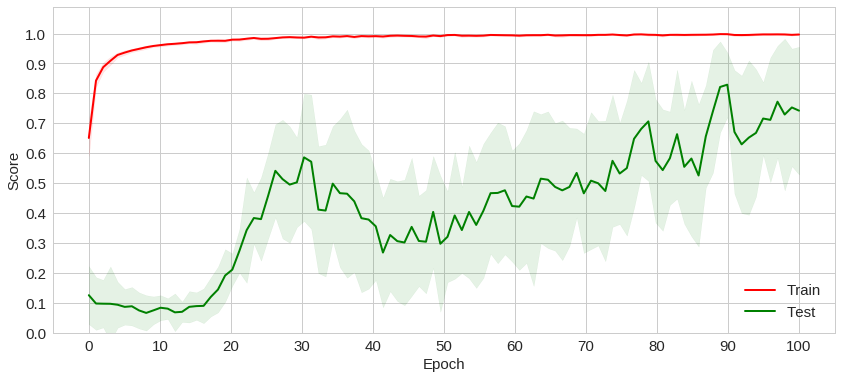

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

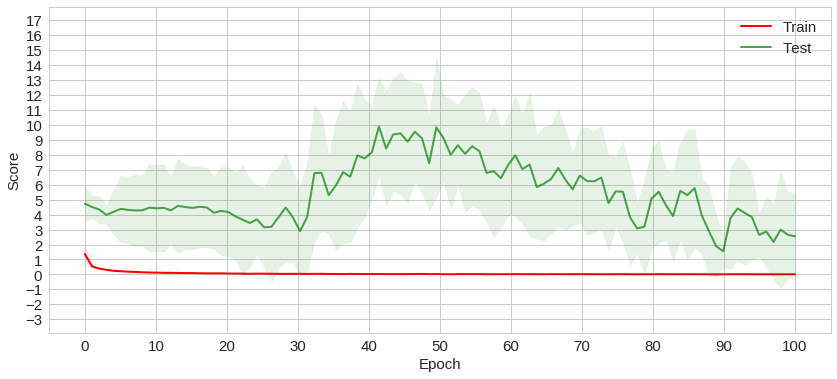

In [26]:
plot_mean_loss(hist)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,19.9))
    plt.show()

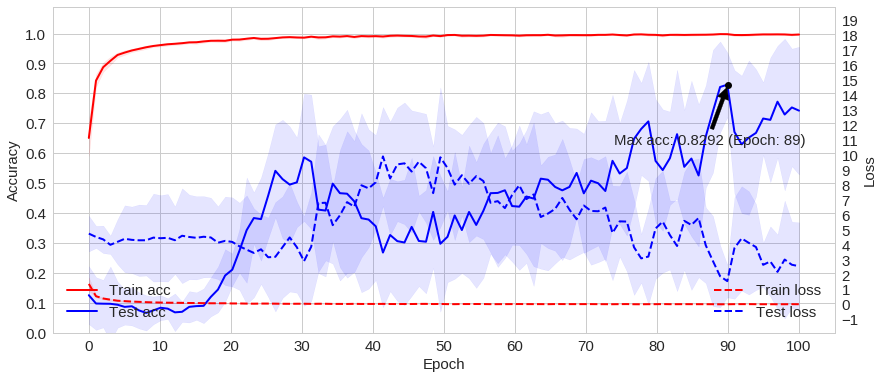

In [32]:
plot_mean(hist)